In [976]:
require(data.table)
require(dada2)
require(phyloseq)
require(ggplot2)
require(RColorBrewer)
require(metacoder)
require(tidyverse)
library("DESeq2")

options(repr.plot.width=20, repr.plot.height=15)

In [977]:
#meta=fread("~/Documents/DE/DE_16S/DE16S_allmeta.csv")
asv_all=fread("~/Documents/DE/DE_16S/ASVs/Run123_ASV_nochim.csv")
taxa=read.csv("~/Documents/DE/DE_16S/ASVs/Run123_taxa.csv", header=TRUE, row.names=1)

In [978]:
growth17=read.csv("~/Documents/DE/DE_16S/meta17_growth_raw.csv")
growth18=read.csv("~/Documents/DE/DE_16S/meta18_growth_raw.csv")

In [979]:
growth=rbind(growth17, growth18)

In [980]:
growth[10:19]=apply(growth[10:19],2, as.numeric)

Warning message in apply(growth[10:19], 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(growth[10:19], 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(growth[10:19], 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(growth[10:19], 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(growth[10:19], 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(growth[10:19], 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(growth[10:19], 2, as.numeric):
“NAs introduced by coercion”


In [981]:
growth$Length_delta=(growth$Length_post-growth$Length_pre)/growth$Length_pre
growth$Weight_delta=(growth$Weight_post-growth$Weight_pre)/growth$Weight_pre

In [983]:
meta=growth

In [984]:
#fix rownames
rows=as.vector(asv_all[,1])
asv_all=asv_all[,-1]
asv_all=apply(asv_all, 2, as.numeric)
row.names(asv_all)=rows$V1
row.names(asv_all)=gsub("__", "_", row.names(asv_all))

In [985]:
#pull out the dilution effect samples
meta_de=meta[meta$Experiment=="Field17"|meta$Experiment=="Lab18",]

In [986]:
asv_de=asv_all[rownames(asv_all) %in% meta_de$UniqueID,]

In [987]:
asv_de=asv_de[rowSums(asv_de)>10000,]

In [988]:
asv_de=asv_de[,colSums(asv_de)>0]

In [989]:
taxa_de=taxa[rownames(taxa)%in% colnames(asv_de),]

In [990]:
#for some reason the bracket subsetting was having a hard time with the NAs
taxa_de_clean=subset(taxa_de, Kingdom!="Eukaryota")
taxa_de_clean=subset(taxa_de_clean, Order!="Chloroplast"|is.na(Order))

In [991]:
table(taxa_de$Kingdom)


  Archaea  Bacteria Eukaryota 
      196     14266       163 

In [992]:
table(taxa_de_clean$Kingdom)


 Archaea Bacteria 
     196    13988 

In [993]:
taxa_de=as.matrix(taxa_de_clean)
meta_de=as.data.frame(meta_de)
row.names(meta_de)=meta_de$UniqueID

In [994]:
head(meta_de)

UniqueID                 Experiment Year Site
2017_WW_LOW_MONO_P17_CV  2017_WW_LOW_MONO_P17_CV  Field17    2017 WW  
2017_WW_HIGH_MONO_B12_CV 2017_WW_HIGH_MONO_B12_CV Field17    2017 WW  
2017_NW_LOW_POLY_B12_MM  2017_NW_LOW_POLY_B12_MM  Field17    2017 NW  
2017_WW_LOW_MONO_P11_CV  2017_WW_LOW_MONO_P11_CV  Field17    2017 WW  
2017_WW_LOW_MONO_B10_CV  2017_WW_LOW_MONO_B10_CV  Field17    2017 WW  
2017_WW_HIGH_MONO_Y16_CV 2017_WW_HIGH_MONO_Y16_CV Field17    2017 WW  
                         Treatment1_Density Treatment2_Diversity Color_Bucket
2017_WW_LOW_MONO_P17_CV  LOW_MONO           NA                   P           
2017_WW_HIGH_MONO_B12_CV HIGH_MONO          NA                   B           
2017_NW_LOW_POLY_B12_MM  LOW_POLY           NA                   B           
2017_WW_LOW_MONO_P11_CV  LOW_MONO           NA                   P           
2017_WW_LOW_MONO_B10_CV  LOW_MONO           NA                   B           
2017_WW_HIGH_MONO_Y16_CV HIGH_MONO          NA                   Y           
                         Number Species Length_pre ⋯ Height_pre Weight_pre
2017_WW_LOW_MONO_P17_CV  17     CV      16.35      ⋯ 5.4        0.51      
2017_WW_HIGH_MONO_B12_CV 12     CV      23.90      ⋯ 6.6        1.22      
2017_NW_LOW_POLY_B12_MM  12     MM      14.45      ⋯ 7.2        0.89      
2017_WW_LOW_MONO_P11_CV  11     CV      20.20      ⋯ 5.7        0.91      
2017_WW_LOW_MONO_B10_CV  10     CV      18.70      ⋯ 5.2        0.76      
2017_WW_HIGH_MONO_Y16_CV 16     CV      20.00      ⋯ 5.4        0.86      
                         Length_post Width_post Height_post Weight_post
2017_WW_LOW_MONO_P17_CV  16.72       13.22      4.91        0.56       
2017_WW_HIGH_MONO_B12_CV 19.92       11.30      5.71        0.82       
2017_NW_LOW_POLY_B12_MM  14.16       12.77      7.04        0.94       
2017_WW_LOW_MONO_P11_CV  21.12       16.59      5.66        0.94       
2017_WW_LOW_MONO_B10_CV  19.58       15.73      4.92        0.97       
2017_WW_HIGH_MONO_Y16_CV 25.08       12.29      5.91        1.04       
                         RFTM_score peacrabs Length_delta Weight_delta
2017_WW_LOW_MONO_P17_CV   NA        NA        0.02262997   0.09803922 
2017_WW_HIGH_MONO_B12_CV 0.5        NA       -0.16652720  -0.32786885 
2017_NW_LOW_POLY_B12_MM   NA        NA       -0.02006920   0.05617978 
2017_WW_LOW_MONO_P11_CV   NA        NA        0.04554455   0.03296703 
2017_WW_LOW_MONO_B10_CV  0.0        NA        0.04705882   0.27631579 
2017_WW_HIGH_MONO_Y16_CV  NA        NA        0.25400000   0.20930233

In [995]:
#replace nas with zeroes for peacrabs
meta_de$peacrabs[is.na(meta_de$peacrabs)]=0


In [996]:
OTU = otu_table(t(asv_de), taxa_are_rows = TRUE)
TAX = tax_table(taxa_de)
SAMP=sample_data(meta_de)

In [997]:
SAMP$Species=gsub("MM", "AM", SAMP$Species)

In [998]:
#make peacrabs into a factor
SAMP$peacrabs=factor(SAMP$peacrabs)

In [840]:
#SAMP$RFTM_score=factor(SAMP$RFTM_score)

In [999]:
#make a simpler rftm factor without 0.5 and combining 4 and 5
SAMP$RFTM_simp=factor(SAMP$RFTM_score)
SAMP$RFTM_simp=sub("0.5", "1", SAMP$RFTM_simp)
SAMP$RFTM_simp=sub("5", "4", SAMP$RFTM_simp)

In [1000]:
#make RFTM presence absence
SAMP$RFTM_pa=ifelse(SAMP$RFTM_score=="0", 0, 1)
SAMP$RFTM_pa=factor(SAMP$RFTM_pa)

In [1001]:
table(SAMP$RFTM_pa, SAMP$Year)

   
    2017 2018
  0  263   82
  1  126   19

In [1002]:
table(SAMP$peacrabs, SAMP$Year)

   
    2017 2018
  0 1067  101
  1   63    0
  2    3    0

In [1003]:
#transform otu counts
OTU=transform_sample_counts(OTU, function(x) 1000000 * x/sum(x))

In [1004]:
#make phyloseq object
DE = phyloseq(OTU, TAX, SAMP)

In [1005]:
DE

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14184 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 14184 taxa by 6 taxonomic ranks ]

In [1006]:
sample_data_clean=sample_data(DE)

In [1007]:
sample_data_clean

UniqueID                 Experiment Year Site
2017_NW_HIGH_MONO_B1_CV  2017_NW_HIGH_MONO_B1_CV  Field17    2017 NW  
2017_NW_HIGH_MONO_B11_CV 2017_NW_HIGH_MONO_B11_CV Field17    2017 NW  
2017_NW_HIGH_MONO_B12_CV 2017_NW_HIGH_MONO_B12_CV Field17    2017 NW  
2017_NW_HIGH_MONO_B14_CV 2017_NW_HIGH_MONO_B14_CV Field17    2017 NW  
2017_NW_HIGH_MONO_B18_CV 2017_NW_HIGH_MONO_B18_CV Field17    2017 NW  
2017_NW_HIGH_MONO_P1_CV  2017_NW_HIGH_MONO_P1_CV  Field17    2017 NW  
2017_NW_HIGH_MONO_P12_CV 2017_NW_HIGH_MONO_P12_CV Field17    2017 NW  
2017_NW_HIGH_MONO_P14_CV 2017_NW_HIGH_MONO_P14_CV Field17    2017 NW  
2017_NW_HIGH_MONO_P16_CV 2017_NW_HIGH_MONO_P16_CV Field17    2017 NW  
2017_NW_HIGH_MONO_P8_CV  2017_NW_HIGH_MONO_P8_CV  Field17    2017 NW  
2017_NW_HIGH_MONO_P9_CV  2017_NW_HIGH_MONO_P9_CV  Field17    2017 NW  
2017_NW_HIGH_MONO_R18_CV 2017_NW_HIGH_MONO_R18_CV Field17    2017 NW  
2017_NW_HIGH_MONO_R4_CV  2017_NW_HIGH_MONO_R4_CV  Field17    2017 NW  
2017_NW_HIGH_MONO_R6_CV  2017_NW_HIGH_MONO_R6_CV  Field17    2017 NW  
2017_NW_HIGH_MONO_Y9_CV  2017_NW_HIGH_MONO_Y9_CV  Field17    2017 NW  
2017_NW_HIGH_POLY_B1_CV  2017_NW_HIGH_POLY_B1_CV  Field17    2017 NW  
2017_NW_HIGH_POLY_B11_CV 2017_NW_HIGH_POLY_B11_CV Field17    2017 NW  
2017_NW_HIGH_POLY_B14_CV 2017_NW_HIGH_POLY_B14_CV Field17    2017 NW  
2017_NW_HIGH_POLY_P7_CV  2017_NW_HIGH_POLY_P7_CV  Field17    2017 NW  
2017_NW_HIGH_POLY_R1_CV  2017_NW_HIGH_POLY_R1_CV  Field17    2017 NW  
2017_NW_LOW_MONO_B17_CV  2017_NW_LOW_MONO_B17_CV  Field17    2017 NW  
2017_NW_LOW_MONO_B3_CV   2017_NW_LOW_MONO_B3_CV   Field17    2017 NW  
2017_NW_LOW_MONO_P11_CV  2017_NW_LOW_MONO_P11_CV  Field17    2017 NW  
2017_NW_LOW_MONO_P17_CV  2017_NW_LOW_MONO_P17_CV  Field17    2017 NW  
2017_NW_LOW_MONO_P5_CV   2017_NW_LOW_MONO_P5_CV   Field17    2017 NW  
2017_NW_LOW_MONO_P7_CV   2017_NW_LOW_MONO_P7_CV   Field17    2017 NW  
2017_NW_LOW_MONO_R1_CV   2017_NW_LOW_MONO_R1_CV   Field17    2017 NW  
2017_NW_LOW_MONO_R11_CV  2017_NW_LOW_MONO_R11_CV  Field17    2017 NW  
2017_NW_LOW_MONO_R14_CV  2017_NW_LOW_MONO_R14_CV  Field17    2017 NW  
2017_NW_LOW_MONO_R16_CV  2017_NW_LOW_MONO_R16_CV  Field17    2017 NW  
⋮                        ⋮                        ⋮          ⋮    ⋮   
2018_LOW_POLY_LP1Y12_IR  2018_LOW_POLY_LP1Y12_IR  Lab18      2018 NA  
2018_LOW_POLY_LP1Y43_CV  2018_LOW_POLY_LP1Y43_CV  Lab18      2018 NA  
2018_LOW_POLY_LP51_MB    2018_LOW_POLY_LP51_MB    Lab18      2018 NA  
2018_LOW_POLY_LP52_MB    2018_LOW_POLY_LP52_MB    Lab18      2018 NA  
2018_LOW_POLY_LP53_MM    2018_LOW_POLY_LP53_MM    Lab18      2018 NA  
2018_LOW_POLY_LP5G15_CV  2018_LOW_POLY_LP5G15_CV  Lab18      2018 NA  
2018_LOW_POLY_LP5G9_CV   2018_LOW_POLY_LP5G9_CV   Lab18      2018 NA  
2018_LOW_POLY_LP5O45_CV  2018_LOW_POLY_LP5O45_CV  Lab18      2018 NA  
2018_LOW_POLY_LP5O51_CV  2018_LOW_POLY_LP5O51_CV  Lab18      2018 NA  
2018_LOW_POLY_LP5O78_CV  2018_LOW_POLY_LP5O78_CV  Lab18      2018 NA  
2018_LOW_POLY_LP5O83_CV  2018_LOW_POLY_LP5O83_CV  Lab18      2018 NA  
2018_LOW_POLY_LP5W11_IR  2018_LOW_POLY_LP5W11_IR  Lab18      2018 NA  
2018_LOW_POLY_LP5W25_IR  2018_LOW_POLY_LP5W25_IR  Lab18      2018 NA  
2018_LOW_POLY_LP5W41_IR  2018_LOW_POLY_LP5W41_IR  Lab18      2018 NA  
2018_LOW_POLY_LP5W48_IR  2018_LOW_POLY_LP5W48_IR  Lab18      2018 NA  
2018_LOW_POLY_LP5W5_IR   2018_LOW_POLY_LP5W5_IR   Lab18      2018 NA  
2018_LOW_POLY_LP5Y92_CV  2018_LOW_POLY_LP5Y92_CV  Lab18      2018 NA  
2018_LOW_POLY_LP71_MB    2018_LOW_POLY_LP71_MB    Lab18      2018 NA  
2018_LOW_POLY_LP72_MB    2018_LOW_POLY_LP72_MB    Lab18      2018 NA  
2018_LOW_POLY_LP73_MB    2018_LOW_POLY_LP73_MB    Lab18      2018 NA  
2018_LOW_POLY_LP74_MM    2018_LOW_POLY_LP74_MM    Lab18      2018 NA  
2018_LOW_POLY_LP75_MM    2018_LOW_POLY_LP75_MM    Lab18      2018 NA  
2018_LOW_POLY_LP7O11_CV  2018_LOW_POLY_LP7O11_CV  Lab18      2018 NA  
2018_LOW_POLY_LP7O23_CV  2018_LOW_POLY_LP7O23_CV  Lab18      2018 NA  
2018_LOW_POLY_LP7Y16_IR  2018_LOW_POLY_LP7Y16_IR 

In [1008]:
write.csv(sample_data_clean, "~/Documents/DE/16S_manuscript/Submit/TableS3.csv")

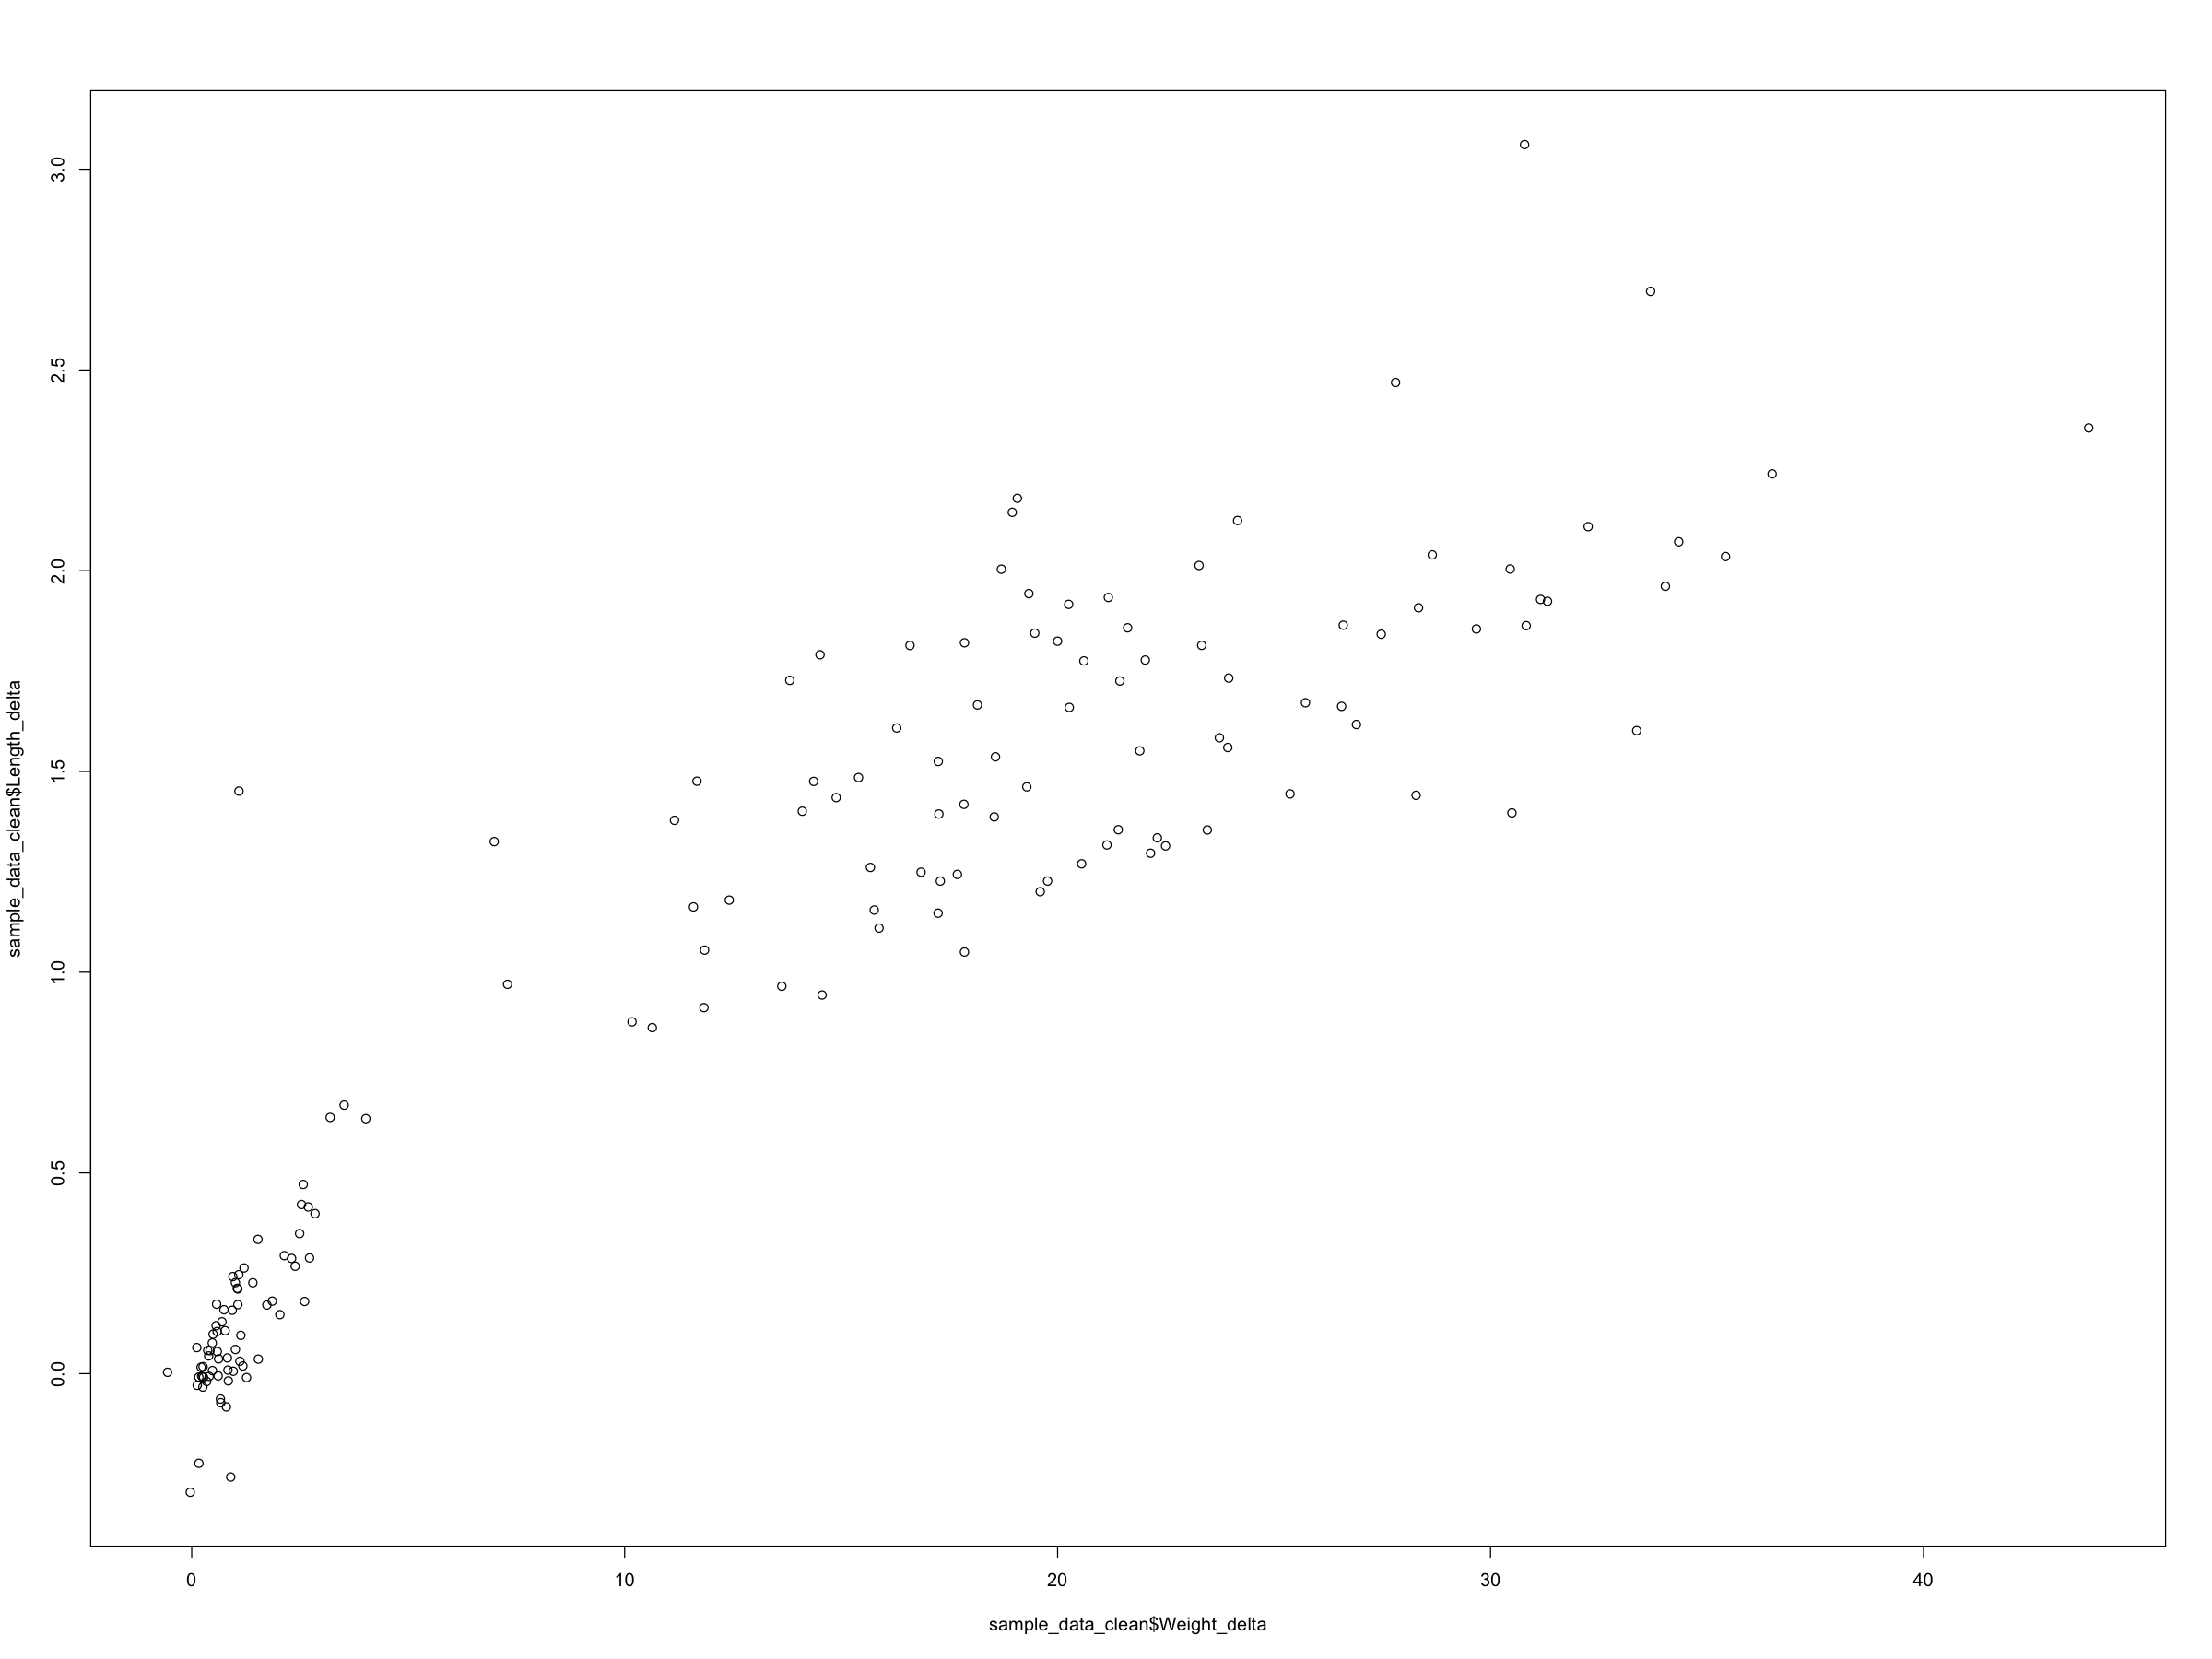

In [1009]:
plot(sample_data_clean$Weight_delta, sample_data_clean$Length_delta)

In [1010]:
mycolors= colorRampPalette(brewer.pal(8, "Accent"))(4)

Warning message:
“Removed 32 rows containing non-finite outside the scale range (`stat_boxplot()`).”


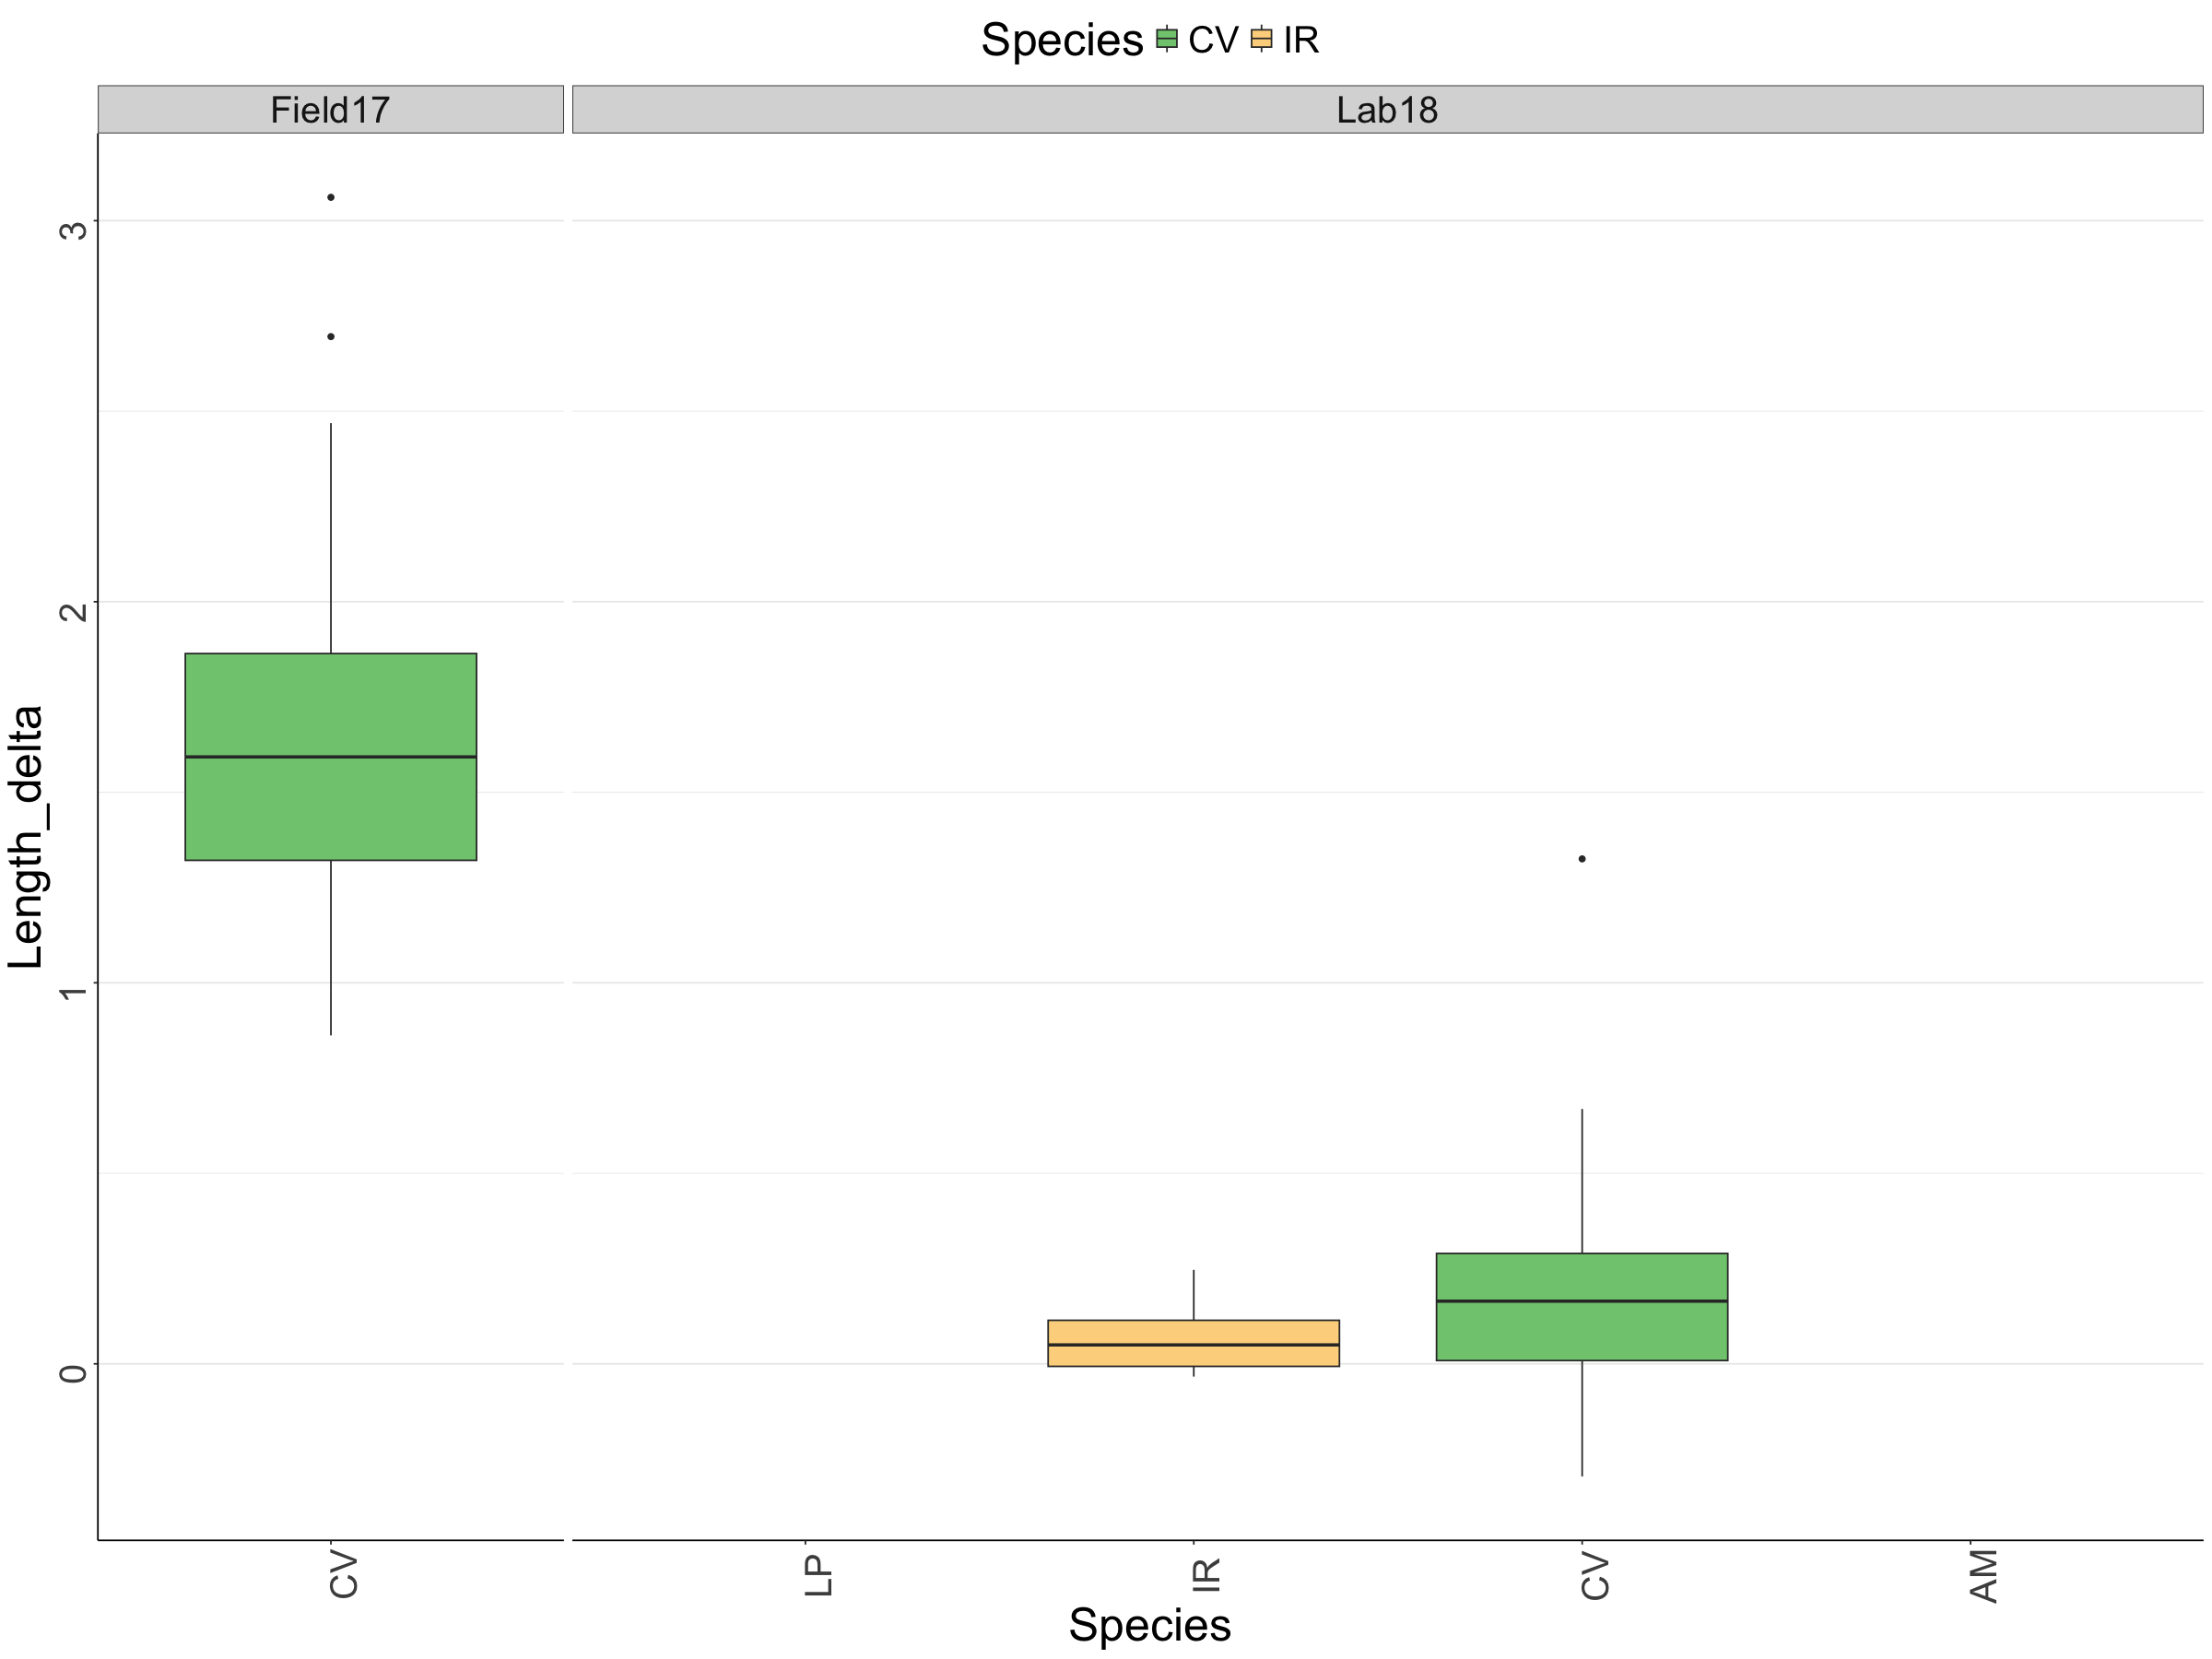

In [1011]:
ggplot(sample_data_clean, aes(x=Species, y=Length_delta, fill=Species)) + 
  geom_boxplot()+
scale_fill_manual(values=mycolors)+
facet_grid(.~Experiment, scales="free_x", space="free")+
theme_bw()+
scale_x_discrete(limits = rev)+
theme(legend.position="top", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.line=element_line(color="black"), axis.text=element_text(angle=90),
          text = element_text(size=30))

In [1012]:
ggsave(file="~/Documents/DE/Figures/Length_change.pdf", width = 15, height=10)

Warning message:
“Removed 32 rows containing non-finite outside the scale range (`stat_boxplot()`).”


Warning message:
“Removed 32 rows containing non-finite outside the scale range (`stat_boxplot()`).”


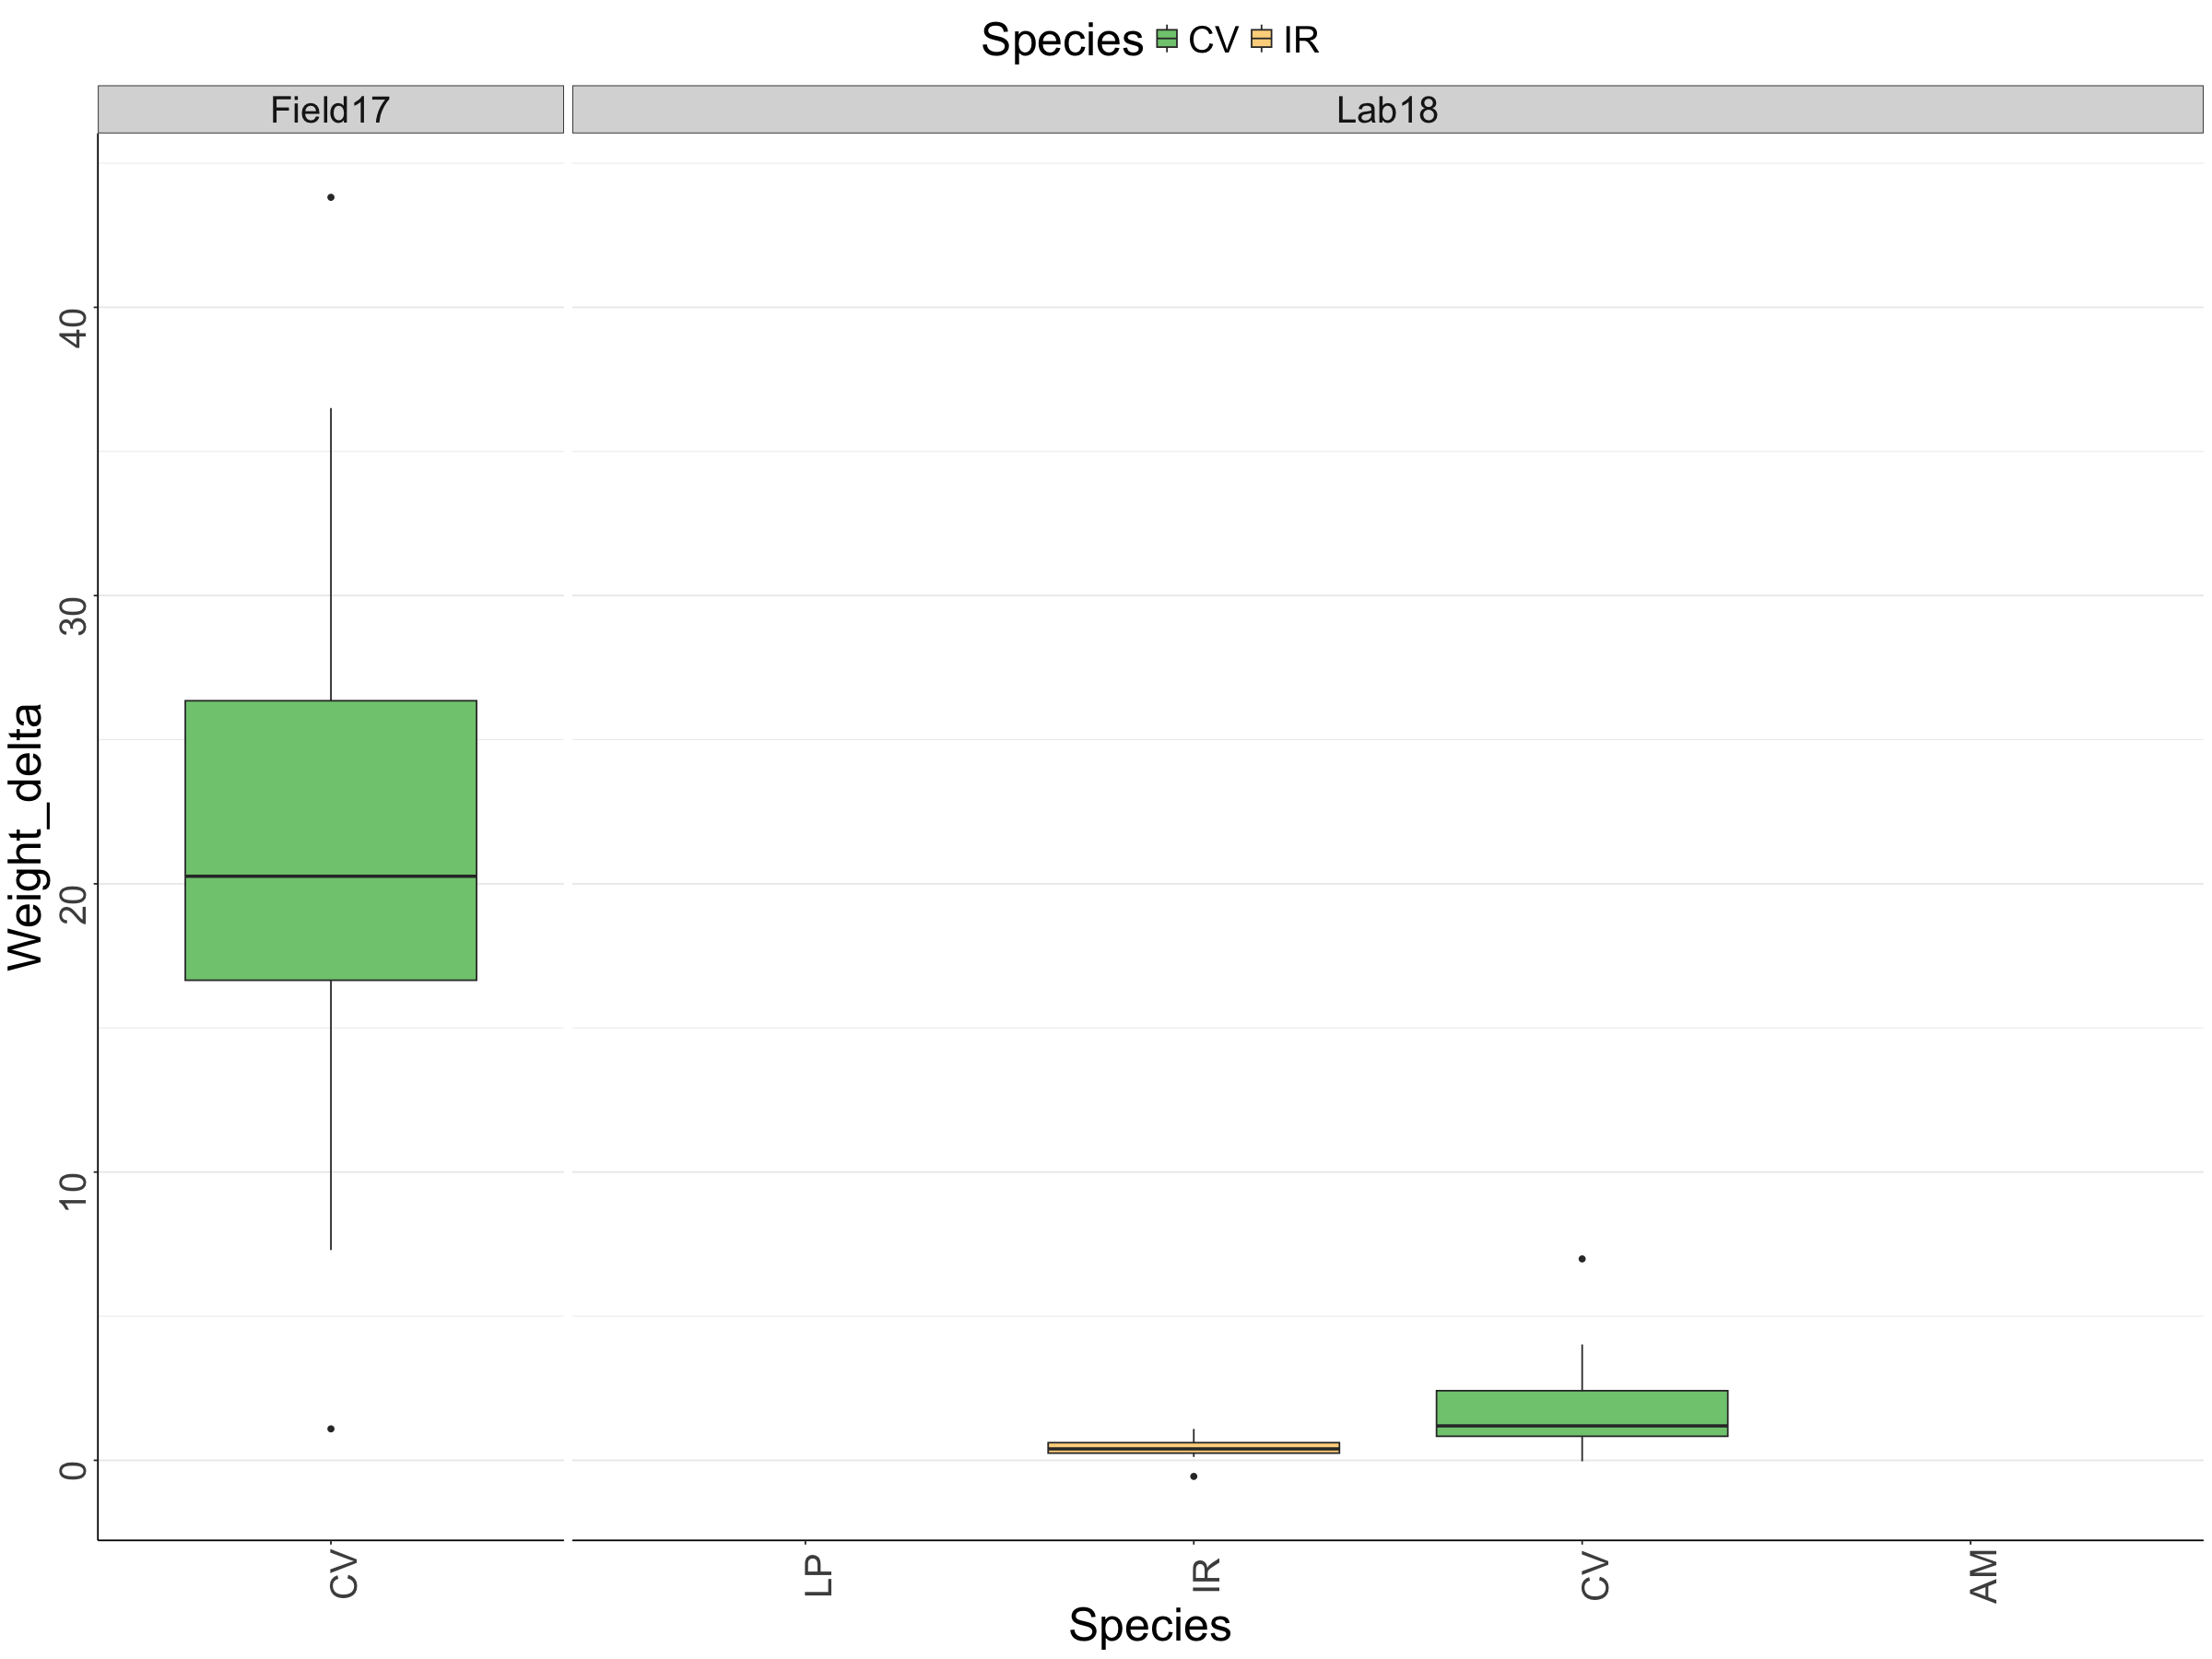

In [1013]:
ggplot(sample_data_clean, aes(x=Species, y=Weight_delta, fill=Species)) + 
  geom_boxplot()+
scale_fill_manual(values=mycolors)+
facet_grid(.~Experiment, scales="free_x", space="free")+
theme_bw()+
scale_x_discrete(limits = rev)+
theme(legend.position="top", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.line=element_line(color="black"), axis.text=element_text(angle=90),
          text = element_text(size=30))

In [856]:
ggsave(file="~/Documents/DE/Figures/Weight_change.pdf", width = 15, height=10)

Warning message:
“Removed 32 rows containing non-finite outside the scale range (`stat_boxplot()`).”


In [1014]:
#separate 2017 and 2018
DE17=subset_samples(DE, Year=="2017")
DE18=subset_samples(DE, Year=="2018")

In [1015]:
SAMP17=sample_data(DE17)

In [1016]:
table(SAMP17$RFTM_score)


  0 0.5   1   2   3   4   5 
 30   9  24  16  14   4   1 

## RFTM FULL SCORE

In [618]:
dds_rftm <- phyloseq_to_deseq2(DE17, ~ RFTM_score * peacrabs + Site)
dds_rftm <- DESeq(dds_rftm, test="Wald", fitType="parametric")
resultsNames(dds_rftm)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7134 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"            "RFTM_score"           "peacrabs_1_vs_0"     
[4] "Site_OY_vs_NW"        "Site_SW_vs_NW"        "RFTM_score.peacrabs1"

In [619]:
respa = results(dds_rftm, name="RFTM_score")
alpha = 0.05
sigpa = respa[which(respa$padj < alpha), ]
sigpa = cbind(as(sigpa, "data.frame"), as(tax_table(DE17)[rownames(sigpa), ], "matrix"))

In [620]:
sigPA_RFTM_tax3=sigpa[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigPA_RFTM_tax3 <- as.matrix(sigPA_RFTM_tax3)

In [621]:
##turn into phyloseq object
sigRFTMTAX <- tax_table(sigPA_RFTM_tax3)
F3_RFTM_wlog <- DE17
tax_table(F3_RFTM_wlog)=sigRFTMTAX

In [622]:
##filter for asvs found in 1/3 of samples
F3_RFTM_wlog_filter <- genefilter_sample(F3_RFTM_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(F3_RFTM_wlog))
F3_RFTM_wlog_prune <- prune_taxa(F3_RFTM_wlog_filter, F3_RFTM_wlog)

In [623]:
F3_RFTM_prune=F3_RFTM_wlog_prune
tax_table(F3_RFTM_prune) <- tax_table(F3_RFTM_prune)[,2:7]
taxmapRFTM <- parse_phyloseq(F3_RFTM_prune)

The following 3 of 8 (37.5%) input indexes have `NA` in their classifications:
   2, 3, 5




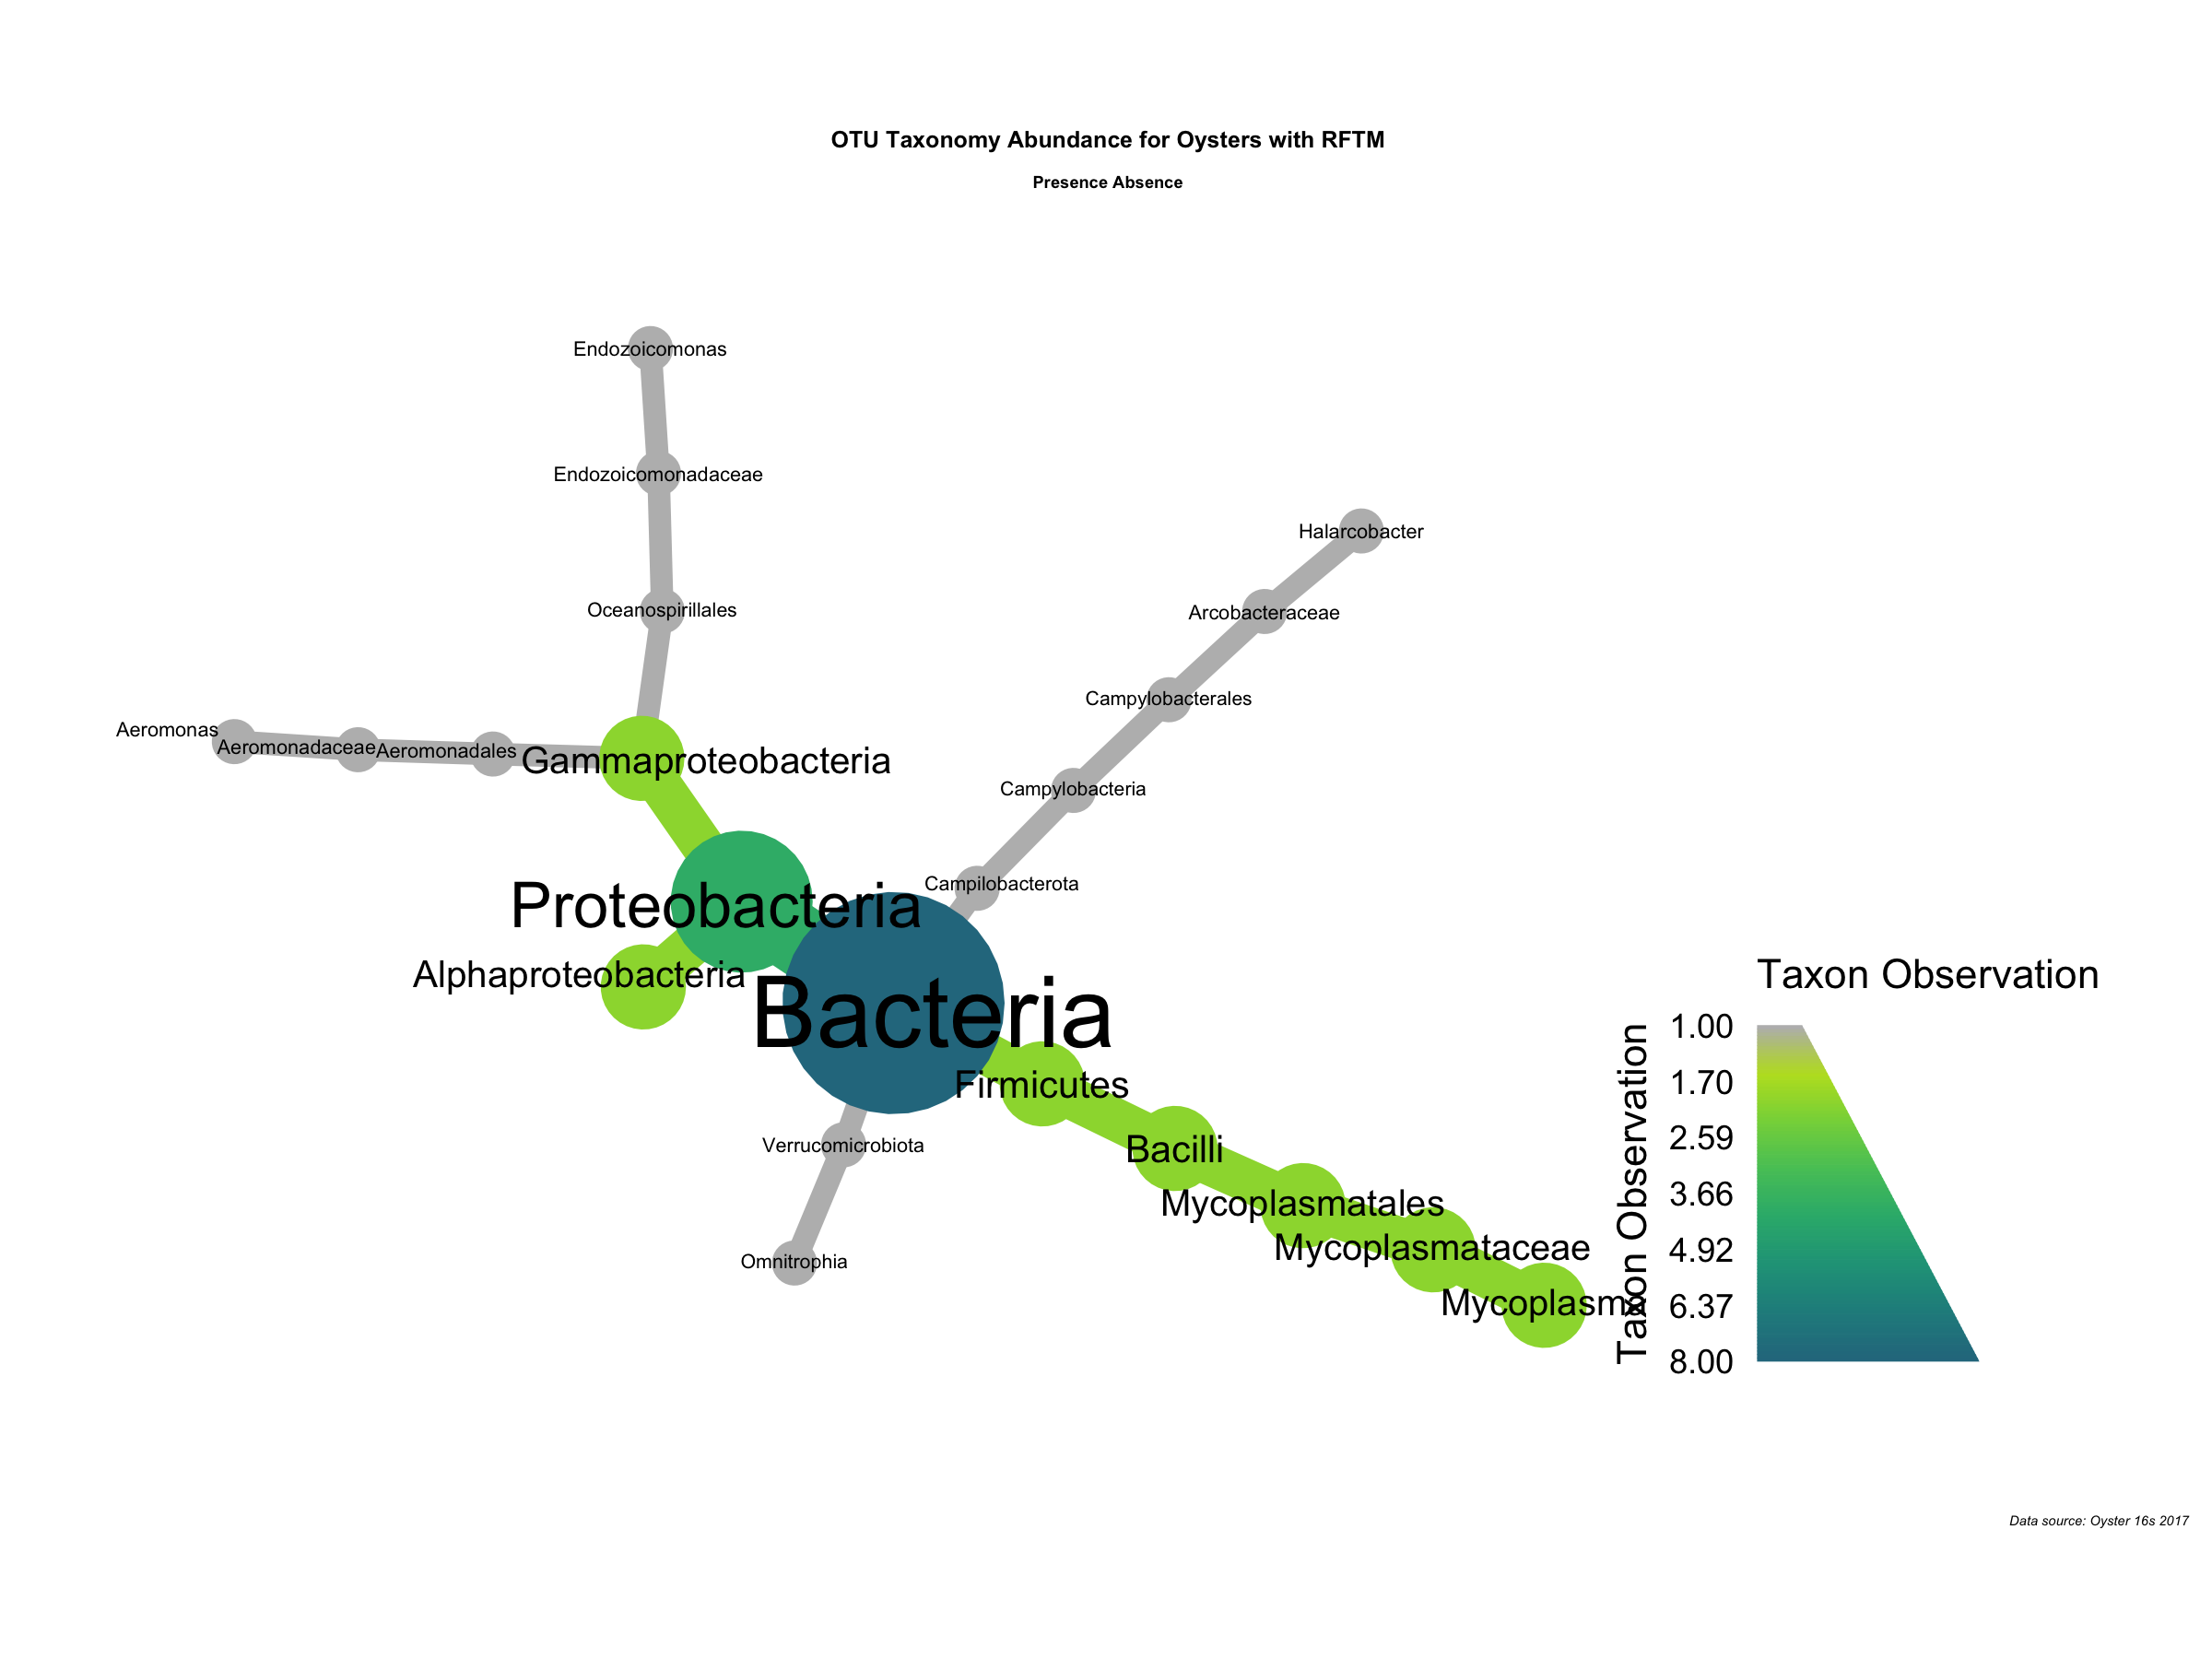

In [624]:
taxmapRFTM %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapRFTM),
            node_color = n_obs(taxmapRFTM),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())+
  labs(title = "OTU Taxonomy Abundance for Oysters with RFTM", 
       subtitle = "Presence Absence",
       caption = "Data source: Oyster 16s 2017")

In [625]:
RFTMLog=as.data.frame(tax_table(F3_RFTM_wlog_prune))
for (i in colnames(RFTMLog)[2:NCOL(RFTMLog)]){
  RFTMLog[[i]] <- (str_c(i, "_", RFTMLog[[i]]))}
RFTMLog=as.data.frame(t(RFTMLog))
RFTMLog=as.data.frame(t(fill(RFTMLog, names(RFTMLog))))
RFTMLog$OTU=row.names(RFTMLog)
RFTMLog$log2FoldChange=as.numeric(RFTMLog$log2FoldChange)

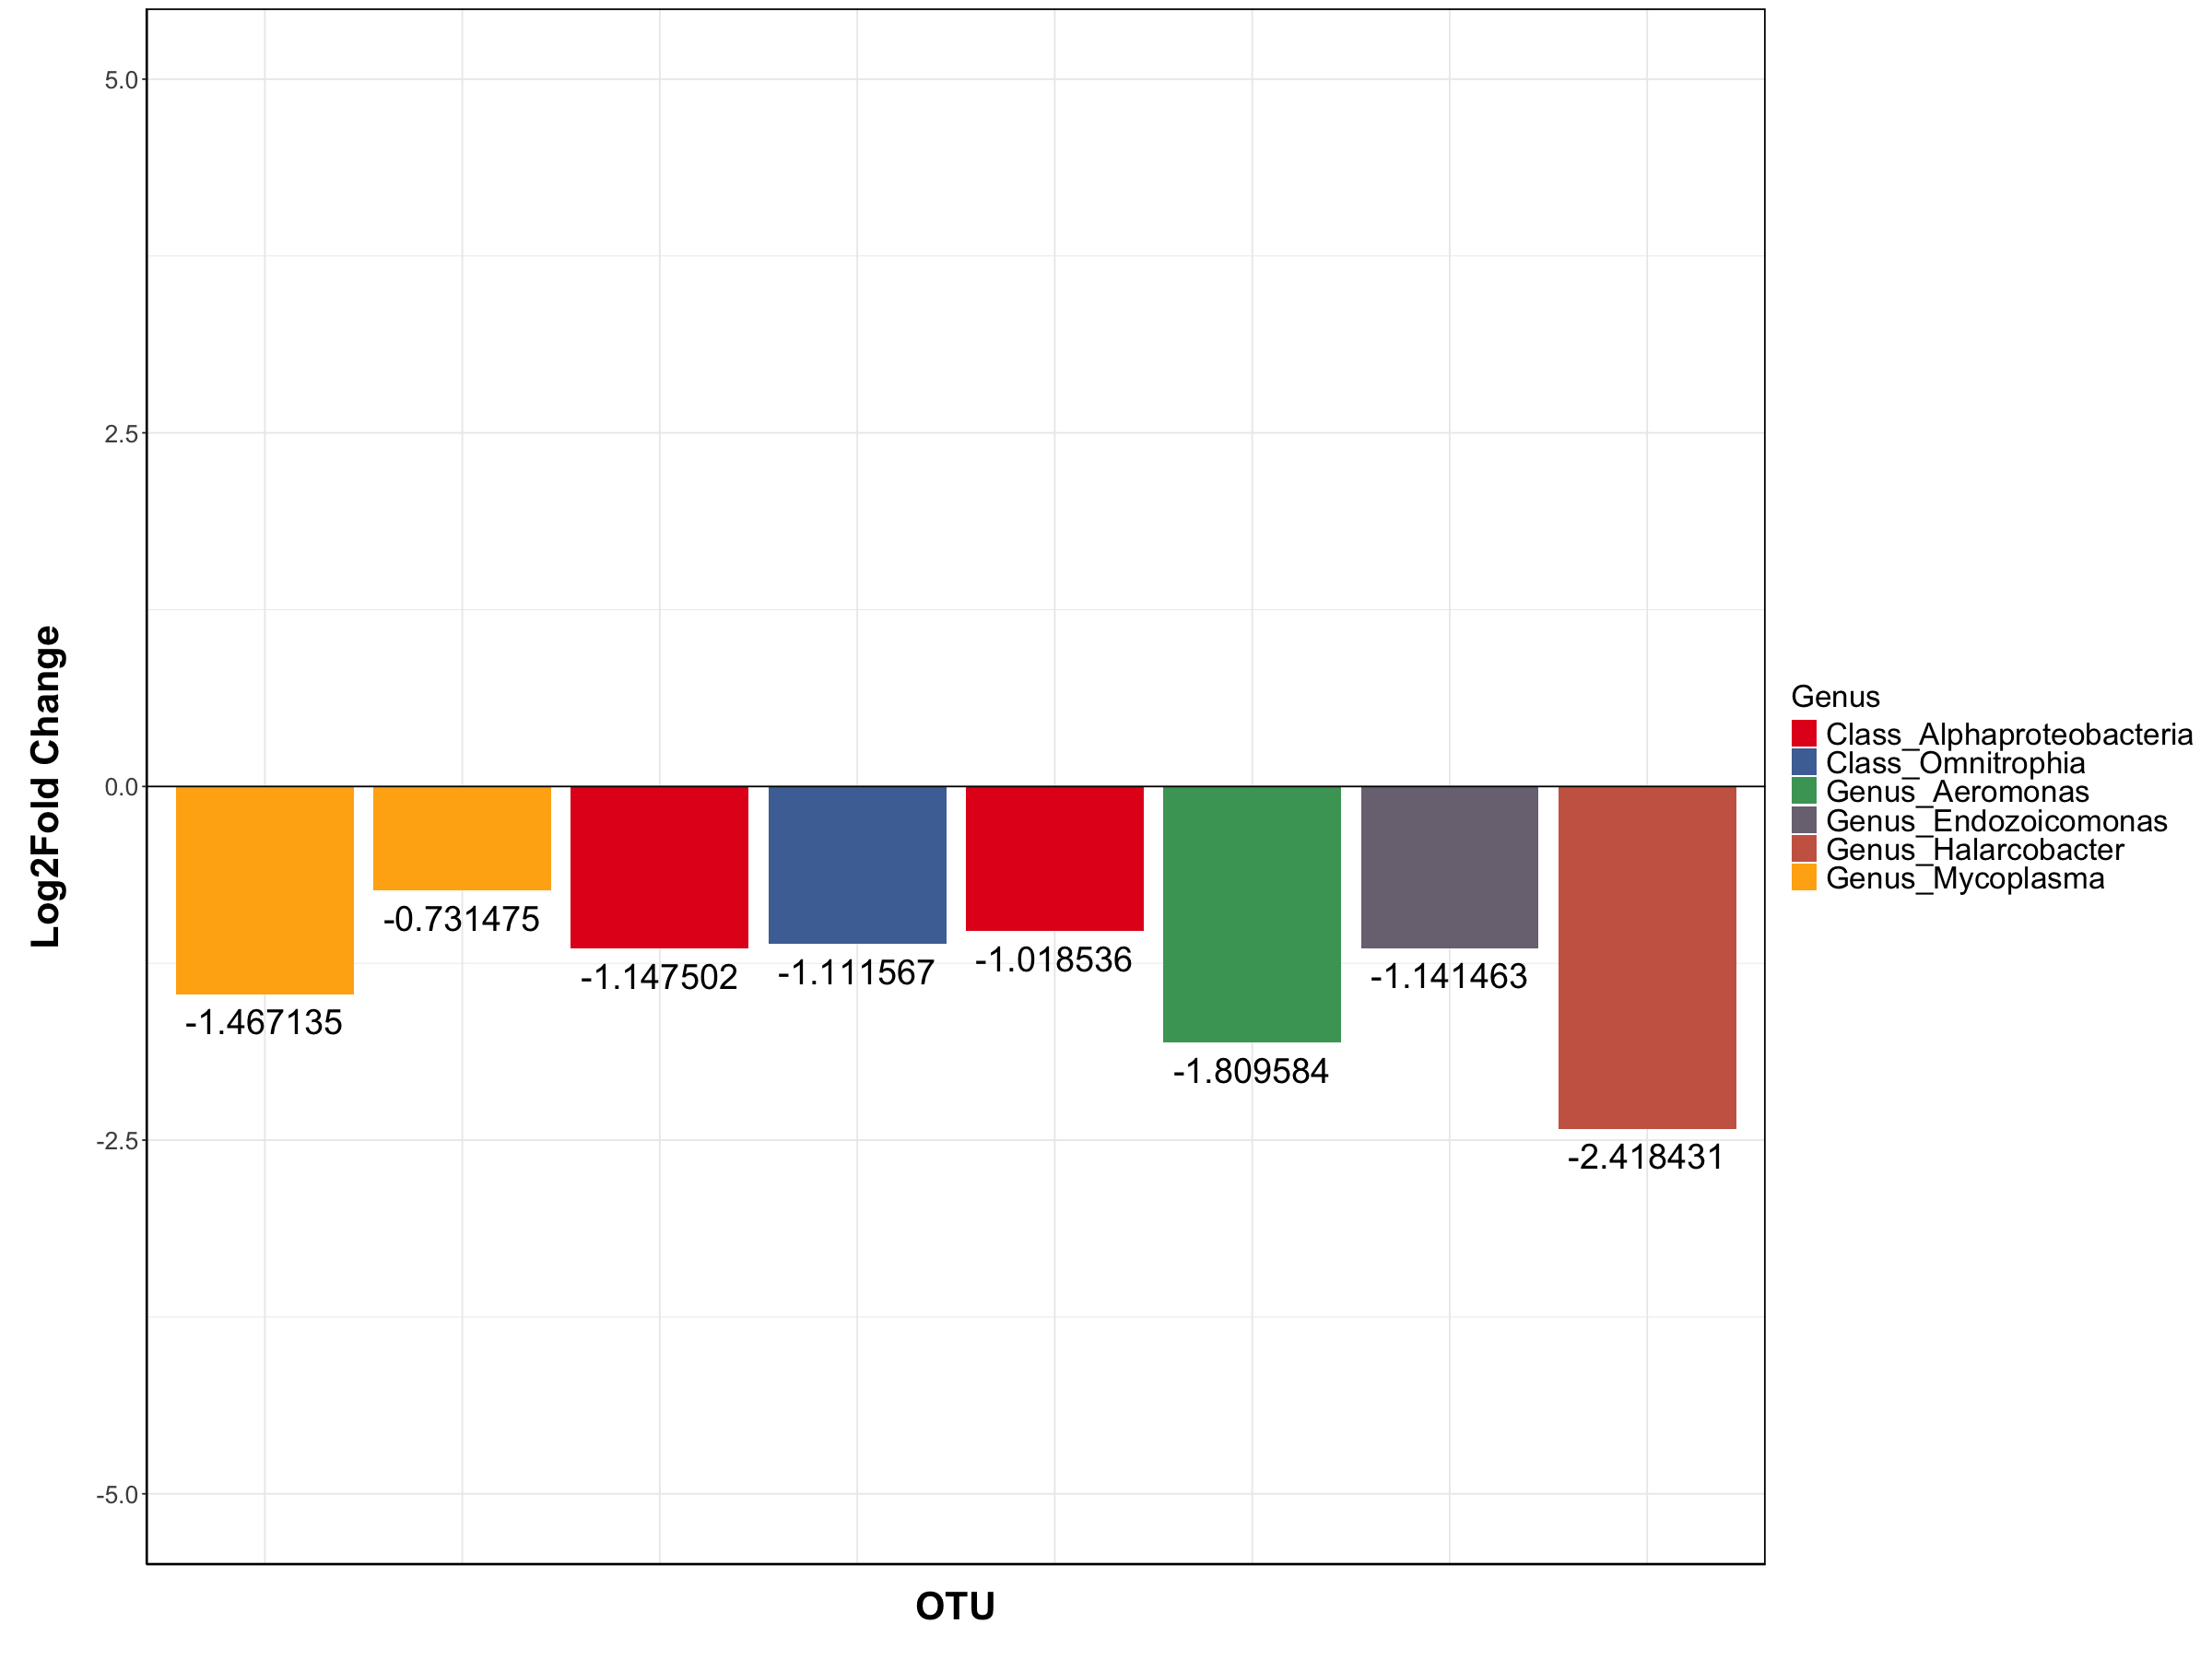

In [626]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(9)

ggplot(RFTMLog,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-5, 5))+
  geom_hline(yintercept = 0)+
theme_bw()+
   theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [627]:
PA=read.csv("~/Documents/DE/DE_16S/Oyster16S_Data23/Results/RFTM_SigOTUs.csv")

In [628]:
RFTMLog[!RFTMLog$OTU %in% PA$OTU,]

log2FoldChange
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGGATAAGTTAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTAAAACTGTCCAGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG -1.809584     
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTATTAAGTCAGAAGTGAAATCCTATGGCTCAACCATAGAACTGCTTTTGAAACTGGTAACCTAGAGTATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG -2.418431     
                                                                                                                                                                                                                                                              Kingdom         
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGGATAAGTTAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTAAAACTGTCCAGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG Kingdom_Bacteria
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTATTAAGTCAGAAGTGAAATCCTATGGCTCAACCATAGAACTGCTTTTGAAACTGGTAACCTAGAGTATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG Kingdom_Bacteria
                                                                                                                                                                                                                                                              Phylum                 
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGGATAAGTTAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTAAAACTGTCCAGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG Phylum_Proteobacteria  
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTATTAAGTCAGAAGTGAAATCCTATGGCTCAACCATAGAACTGCTTTTGAAACTGGTAACCTAGAGTATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG Phylum_Campilobacterota
                                                                                                                                                                                                                                                              Class                    
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGGATAAGTTAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTAAAACTGTCCAGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG Class_Gammaproteobacteria
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTATTAAGTCAGAAGTGAAATCCTATGGCTCAACCATAGAACTGCTTTTGAAACTGGTAACCTAGAGTATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG Class_Campylobacteria    
                                                                                                                                                                                                                                                              Order                  
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGGATAAGTTAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTAAAACTGTCCAGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG Order_Aeromonadales    
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTATTAAGTCAGAAGTGAAATCCTATGGCTCAACCATAGAACTGCTTTTGAAACTGGTAACCTAGAGTATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG Order_Campylobacterales
                                                                                                                              

## significant OTUs presence absence of perkinsus and peacrabs

In [629]:
dds_rftmxpeasite <- phyloseq_to_deseq2(DE17, ~ RFTM_pa * peacrabs + Site)
dds_rftmxpeasite <- DESeq(dds_rftmxpeasite, test="Wald", fitType="parametric")
resultsNames(dds_rftmxpeasite)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7350 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"          "RFTM_pa_1_vs_0"     "peacrabs_1_vs_0"   
[4] "Site_OY_vs_NW"      "Site_SW_vs_NW"      "RFTM_pa1.peacrabs1"

## perkinsus presence absence

In [630]:
respa = results(dds_rftmxpeasite, name="RFTM_pa_1_vs_0")
alpha = 0.05
sigpa = respa[which(respa$padj < alpha), ]
sigpa = cbind(as(sigpa, "data.frame"), as(tax_table(DE17)[rownames(sigpa), ], "matrix"))

In [631]:
sigPA_RFTM_tax3=sigpa[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigPA_RFTM_tax3 <- as.matrix(sigPA_RFTM_tax3)


In [632]:
##turn into phyloseq object
sigPATAX <- tax_table(sigPA_RFTM_tax3)
F3_RFTMPA_wlog <- DE17
tax_table(F3_RFTMPA_wlog)=sigPATAX

In [633]:
##filter for asvs found in 1/3 of samples
F3_RFTMPA_wlog_filter <- genefilter_sample(F3_RFTMPA_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(F3_RFTMPA_wlog))
F3_RFTMPA_wlog_prune <- prune_taxa(F3_RFTMPA_wlog_filter, F3_RFTMPA_wlog)

In [634]:
F3_RFTMPA_prune=F3_RFTMPA_wlog_prune
tax_table(F3_RFTMPA_prune) <- tax_table(F3_RFTMPA_prune)[,2:7]
taxmapRFTMPA <- parse_phyloseq(F3_RFTMPA_prune)

The following 3 of 11 (27.3%) input indexes have `NA` in their classifications:
   4, 5, 7




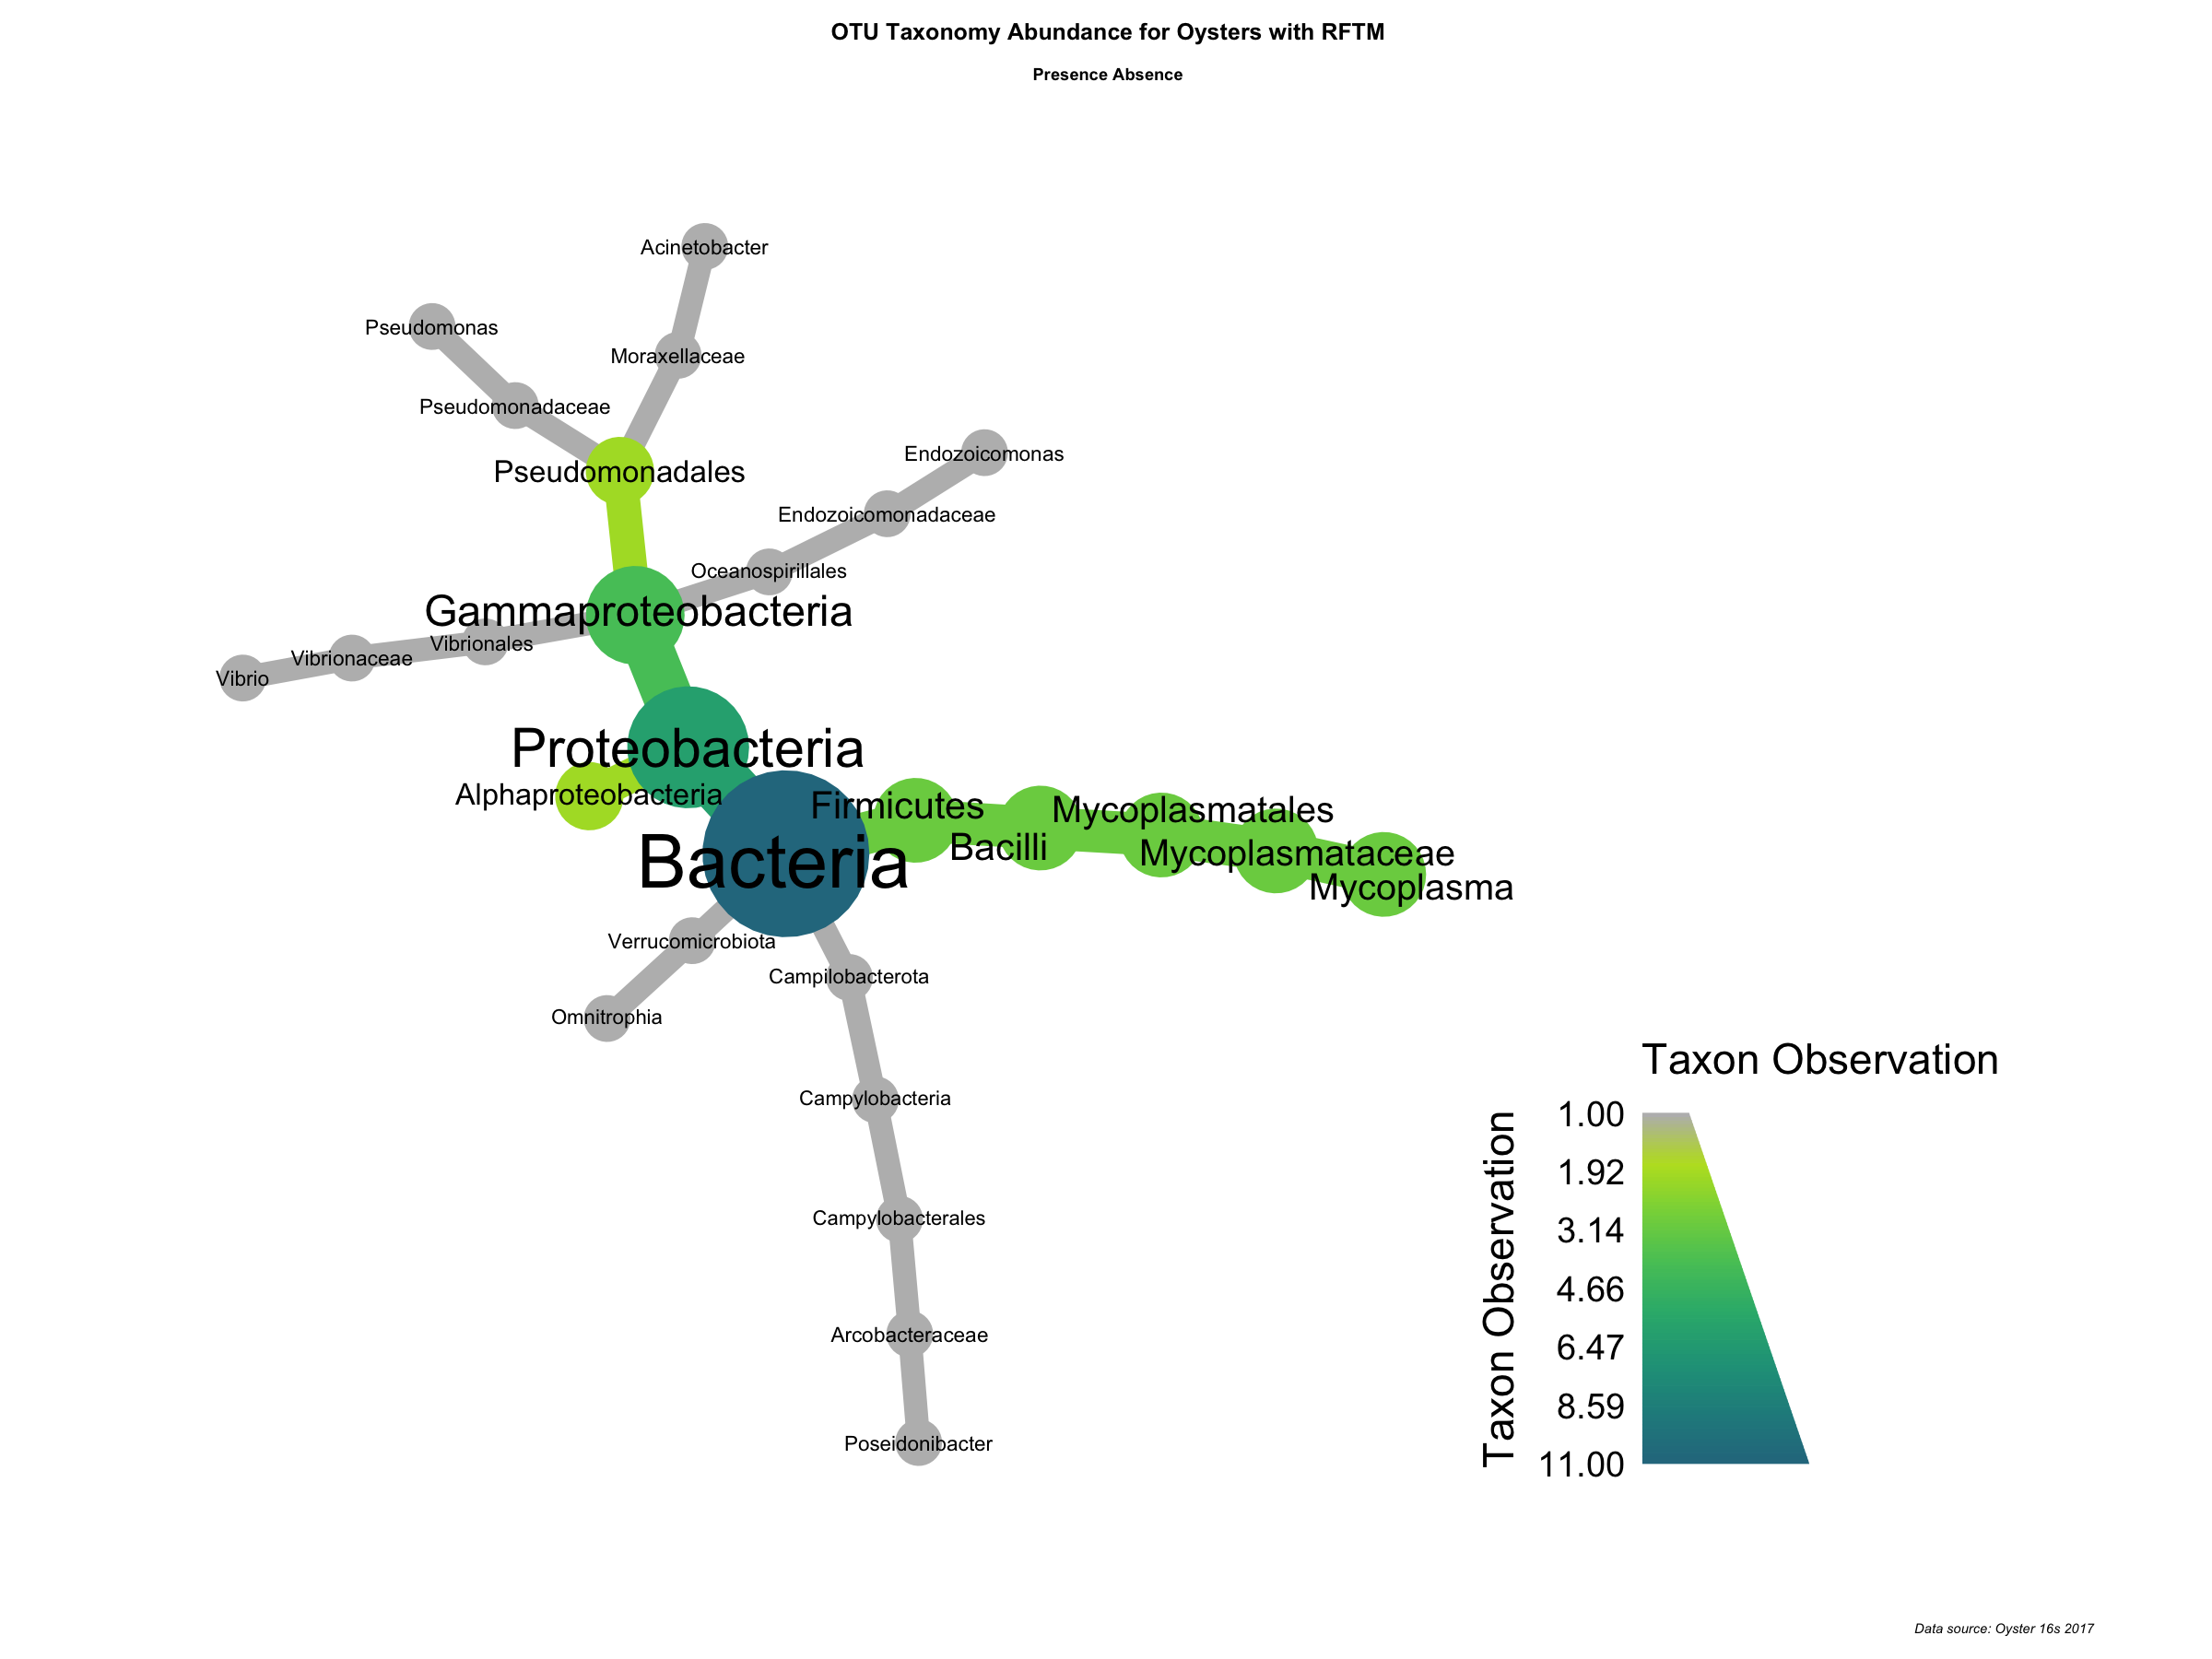

In [635]:
taxmapRFTMPA %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapRFTMPA),
            node_color = n_obs(taxmapRFTMPA),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())+
  labs(title = "OTU Taxonomy Abundance for Oysters with RFTM", 
       subtitle = "Presence Absence",
       caption = "Data source: Oyster 16s 2017")

In [302]:
ggsave(file="~/Documents/DE/Figures/RFTM_taxmap.pdf", width = 15, height=10)

In [303]:
PALog=as.data.frame(tax_table(F3_RFTMPA_wlog_prune))
for (i in colnames(PALog)[2:NCOL(PALog)]){
  PALog[[i]] <- (str_c(i, "_", PALog[[i]]))}
PALog=as.data.frame(t(PALog))
PALog=as.data.frame(t(fill(PALog, names(PALog))))
PALog$OTU=row.names(PALog)
PALog$log2FoldChange=as.numeric(PALog$log2FoldChange)

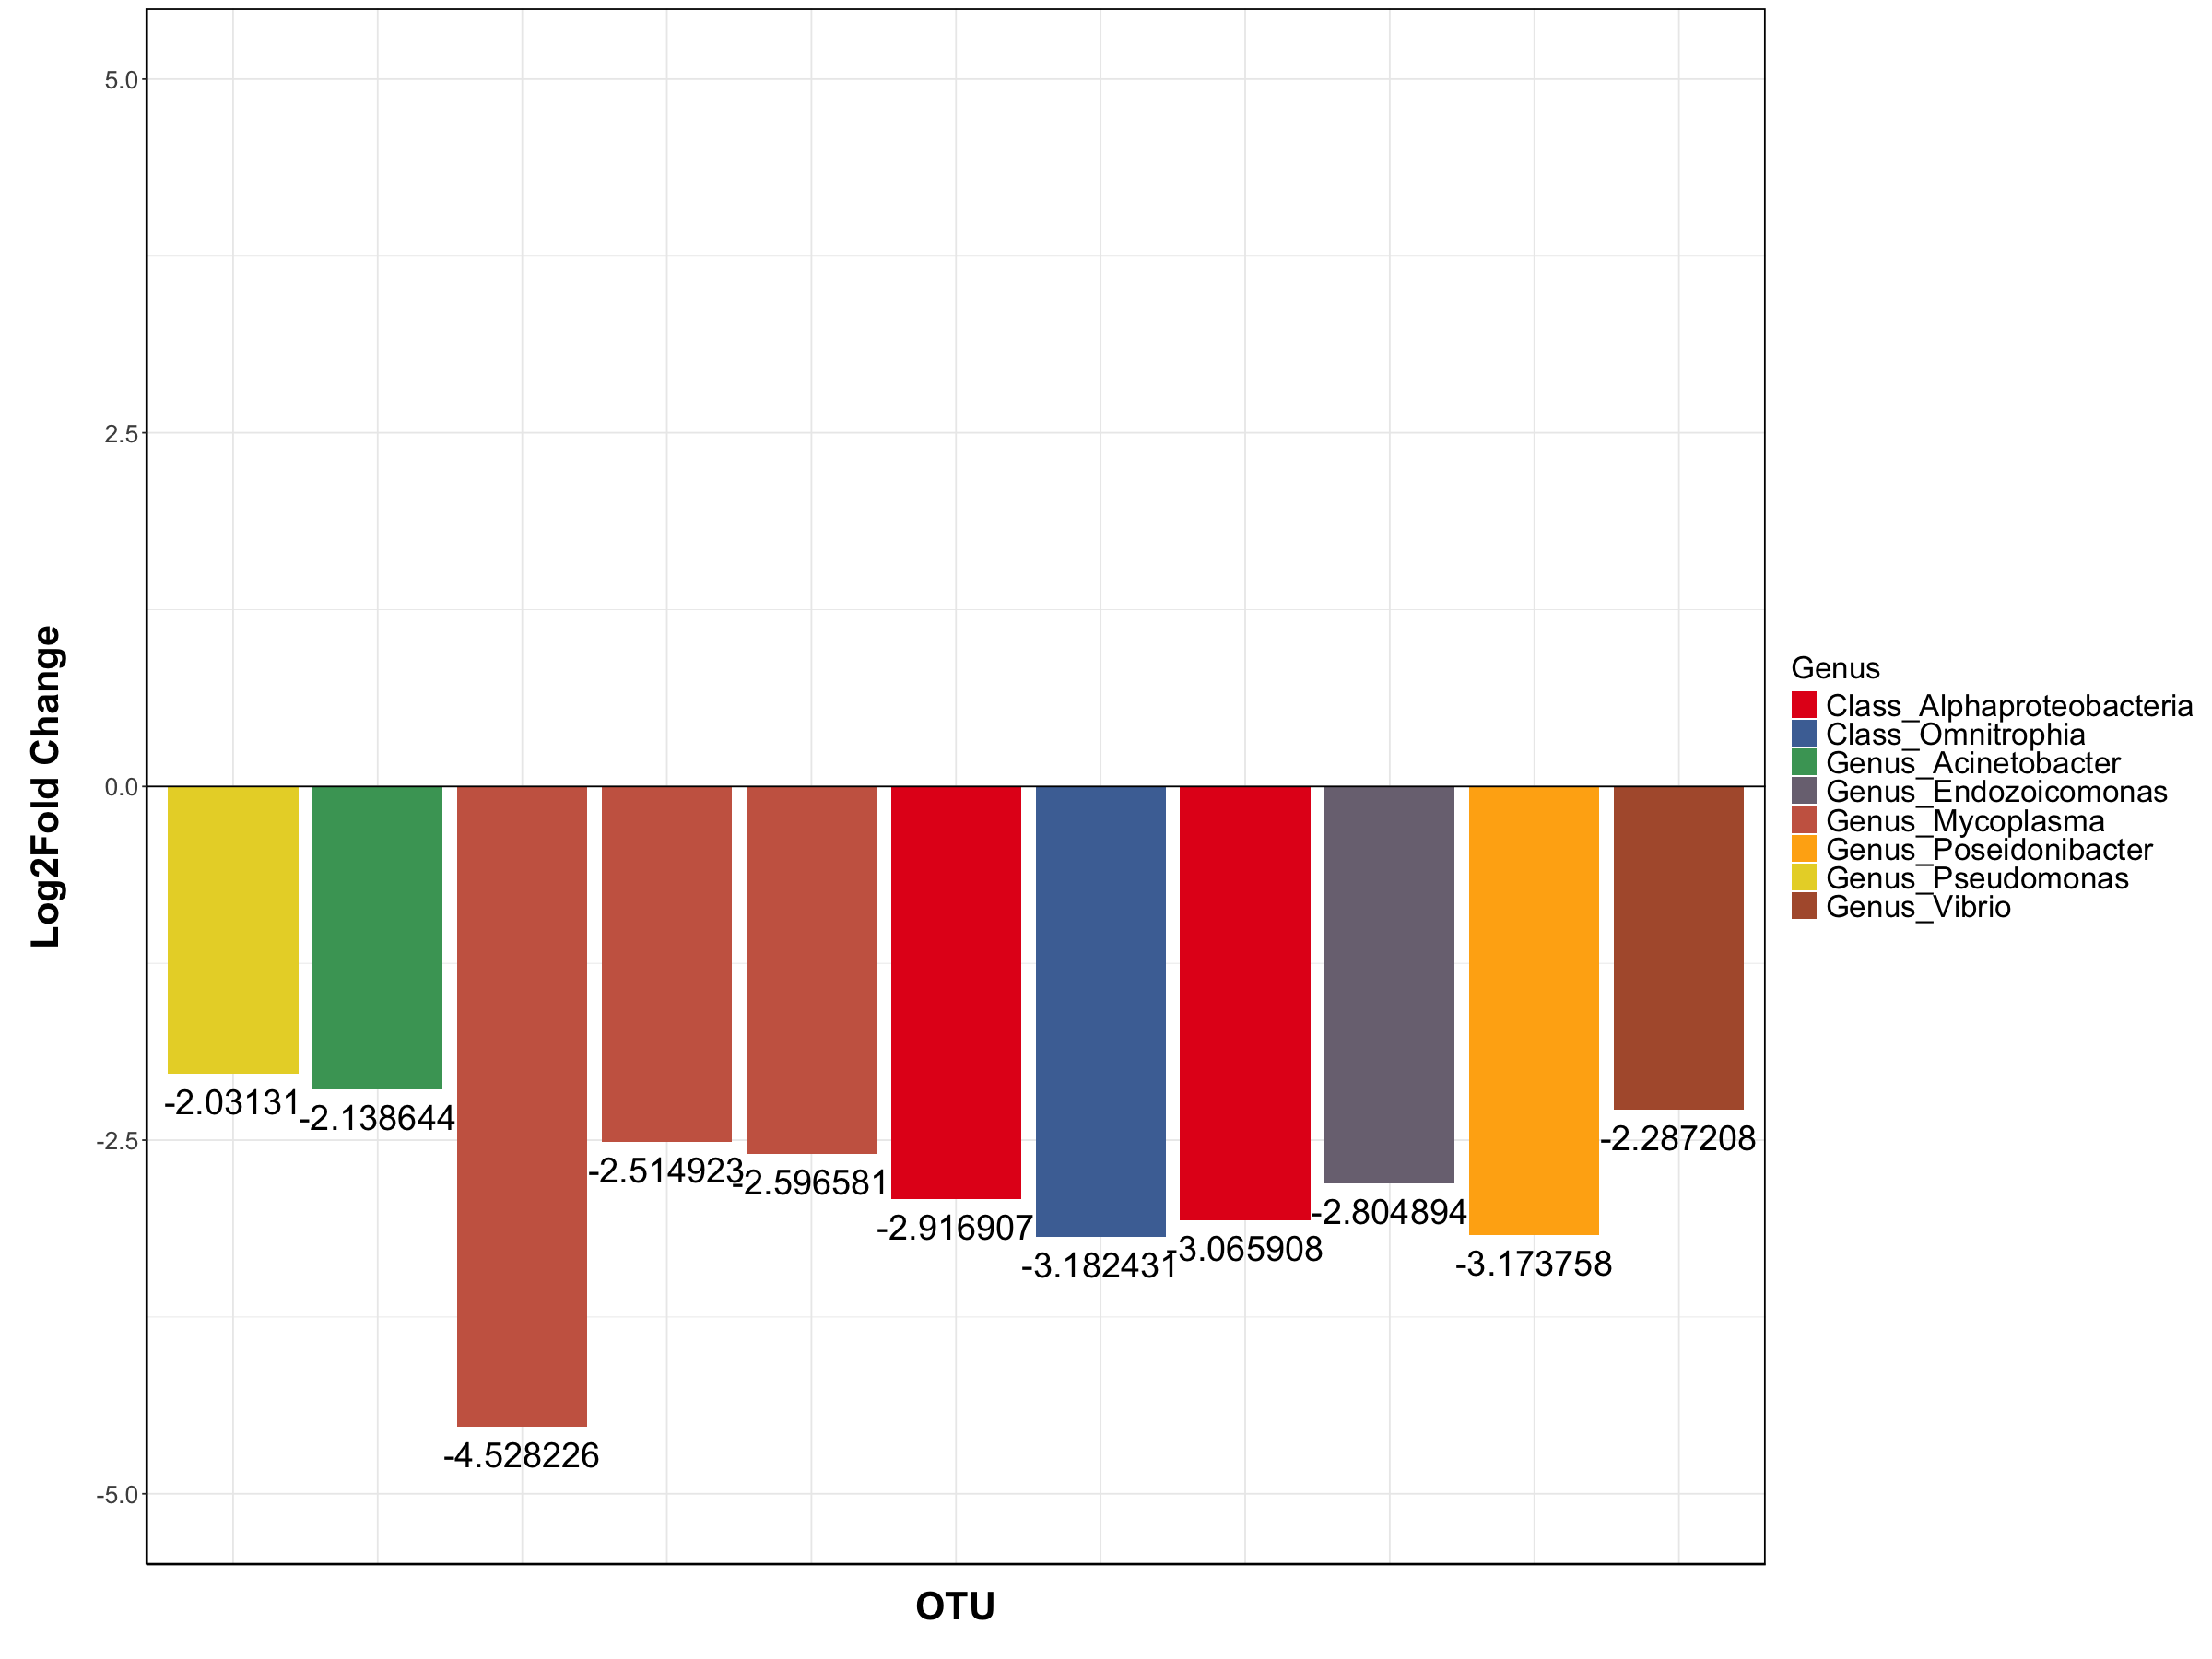

In [304]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(9)

ggplot(PALog,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-5, 5))+
  geom_hline(yintercept = 0)+
theme_bw()+
   theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [305]:
ggsave(file="~/Documents/DE/Figures/RFTM_bar.pdf", width = 15, height=10)

In [555]:
PALog$Perkinsus=PALog$log2FoldChange
PALog$log2FoldChange=NULL

In [523]:
PALog

log2FoldChange
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCTCGGTGCTCAACACCGACCCGCTTTGGATACTGATAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG  -2.514923     
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG  -2.596581     
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTTGTAAGTTTGAAGTGAAATCCAATGGCTCAACCATTGAACTGCTTTGAAAACTGCTTACCTAGAATATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTATTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG -3.173758     
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTCTAGGTGGTTTTGTTAGTTGGATGTGAAAGCCCTCGGCTCAACCGAGGAATTGCATCCAAAACTGCATTACTAGAGTGTGAAAGGGGAAGGCGGAATTCCAAGTGTAGCGGTGAAATGCGTAGATATTTGGAGGAACACCGGTGGCGAAGGCGGCCTTCTGGTTCAACACTGACACTAAAGCGCGAAGGCTAGGGGAGCGAACAGG -3.182431     
TACGAAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGAGTACGTAGGCGGTTAGATTAGTTAGGTGTGAAATCCCGGAGCTCAACTTCGGAGTTGCACTTAATACTGTTTAACTAGAATTCAAGAGGGGAGAGTGGAATTTCCAGTGTAGGGGTGATATCCGTAGATATTGGAAGGAACATCAGAGGCGAAGGCGACTCTCTGGCTTGACATTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACAGG -2.916907     
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG -2.287208     
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGGGTACGTAGGCGGTTTAACCAGTCAGATGTGAAATCCCAGGGCTCAACCTTGGAACTGCATTTGATACTGTTAGACTAGAATCCGAGAGGGGACAGTGGAATTTCCAGTGTAGAGGTGACATCCGTAGATATTGGAAGGAACACCAGAGGCGAAGGCGACTGTCTGGATCGGTATTGACGCTGAGGTACGAAAGTGTGGGTAGCAAACAGG -3.065908     
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACGAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG -2.031310     
TACAGAGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTGCGTAGGCGGCCATTTAAGTCAAATGTGAAATCCCCGAGCTTAACTTGGGAATTGCATTCGATACTGGATGGCTAGAGTATGGGAGAGGATGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCCATCTGGCCTAATACTGACGCTGAGGTACGAAAGCATGGGGAGCAAACAGG -2.138644     
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTGCGTAGGCGGTTTACTAAGTCTGAAGTTAAAGCCTGGGGCTCAACCCCAGCCCGCTTTGGATACTGGTAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAAGAGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG  -4.528226     
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCTACTTAAGTGGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG -2.804894     
                                                                                                                                                                                                                                                              Kingdom         
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCTCGGTGCTCAACACCGACCCGCTTTGGATACTGATAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG  Kingdom_Bacteria
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG  Kingdom_Bacteria
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTTGTAAGTTTGAAGTGAAATCCAATGGCTCAACCATTGAACTGCTTTGAAAACTGCTTACCTAGAATATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACA

In [434]:
write.csv(PALog, "~/Documents/DE/DE_16S/Oyster16S_Data23/Results/RFTM_SigOTUs.csv")

# peacrabs


In [397]:
resultsNames(dds_rftmxpeasite)

[1] "Intercept"          "RFTM_pa_1_vs_0"     "peacrabs_1_vs_0"   
[4] "Site_OY_vs_NW"      "Site_SW_vs_NW"      "RFTM_pa1.peacrabs1"

In [306]:
resPA_pea_F3 <- results(dds_rftmxpeasite, name="peacrabs_1_vs_0")
sigPA_pea_F3 <- resPA_pea_F3[which(resPA_pea_F3$padj < 0.05), ]
sigPA_pea_F3 <- cbind(as(sigPA_pea_F3, "data.frame"), as(tax_table(DE17)[rownames(sigPA_pea_F3), ], "matrix"))
sigPA_pea_F3=sigPA_pea_F3[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigPA_pea_F3 <- as.matrix(sigPA_pea_F3)

In [307]:
##turn into phyloseq object
sigPeaTAX <- tax_table(sigPA_pea_F3)
F3_Pea_wlog <- DE17
tax_table(F3_Pea_wlog)=sigPeaTAX

In [308]:
##filter for asvs found in 1/3 of samples
F3_Pea_wlog_filter <- genefilter_sample(F3_Pea_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(F3_Pea_wlog))
F3_Pea_wlog_prune <- prune_taxa(F3_Pea_wlog_filter, F3_Pea_wlog)

In [309]:
##Heattree
F3_Pea_prune=F3_Pea_wlog_prune
tax_table(F3_Pea_prune) <- tax_table(F3_Pea_prune)[,2:7]
taxmapPeaPA <- parse_phyloseq(F3_Pea_prune)

The following 4 of 17 (23.5%) input indexes have `NA` in their classifications:
   5, 7, 11, 16




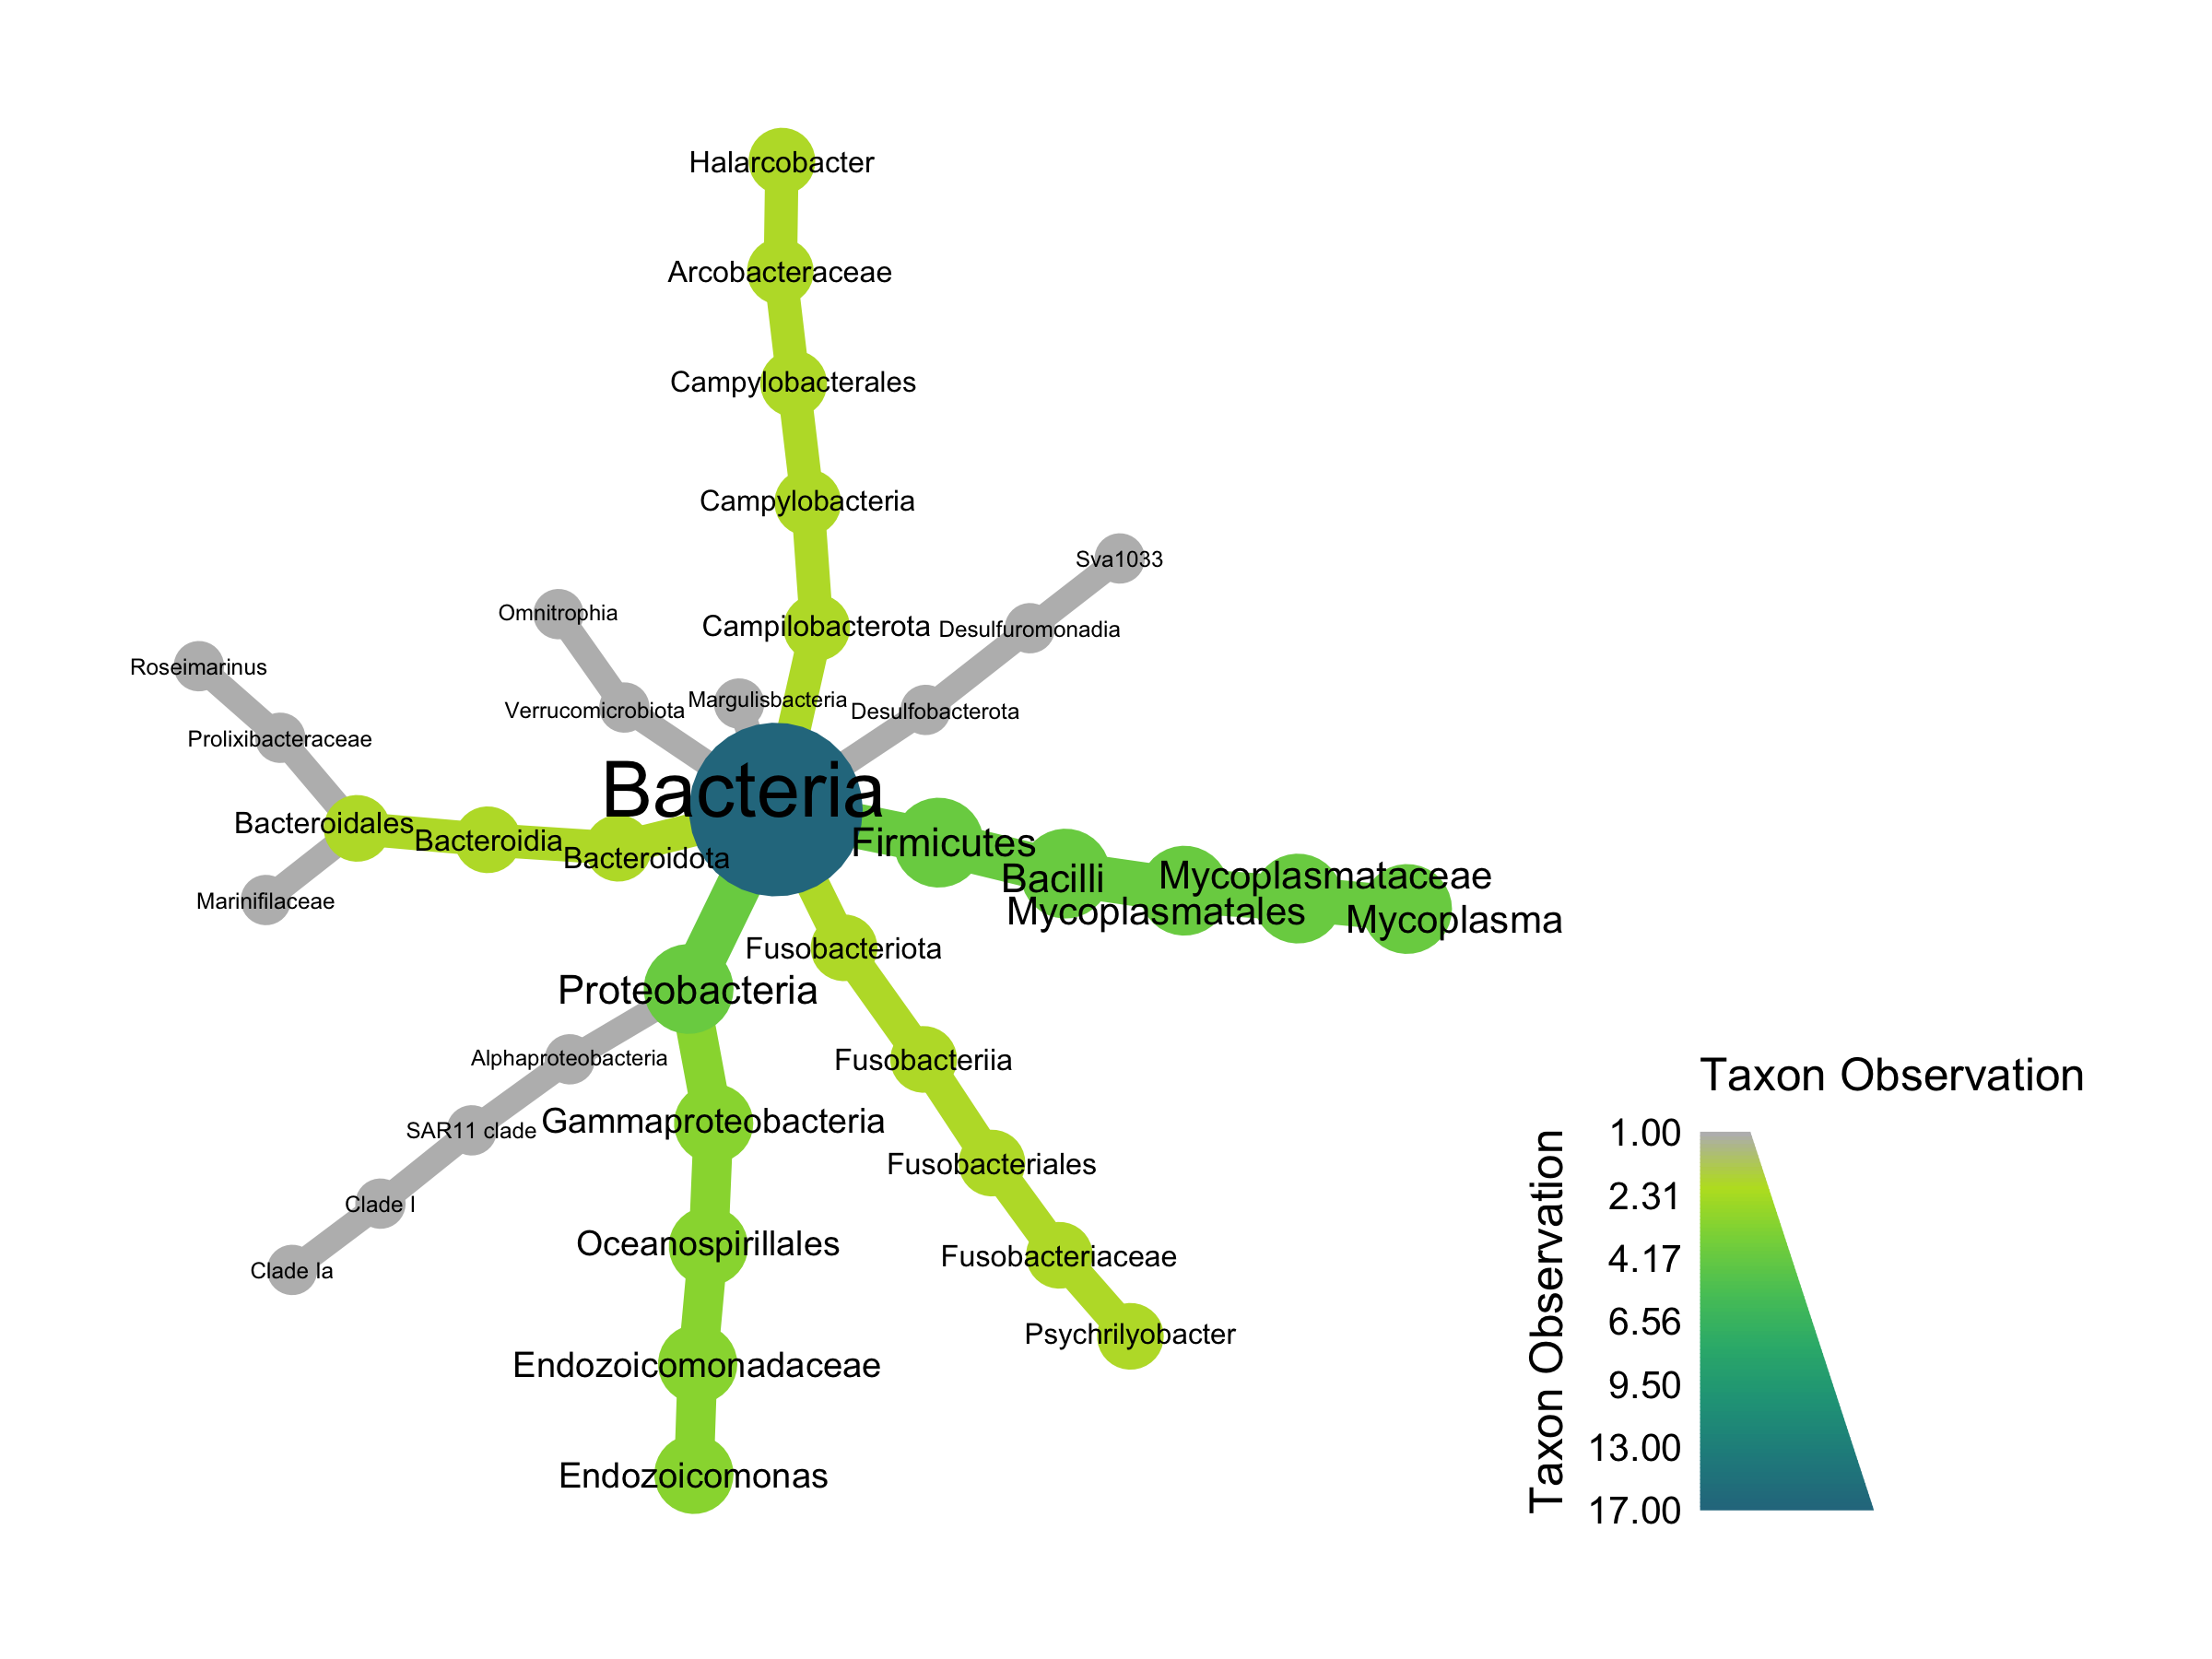

In [310]:
taxmapPeaPA %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapPeaPA),
            node_color = n_obs(taxmapPeaPA),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [311]:
ggsave(file="~/Documents/DE/Figures/Pea_taxmap.pdf", width = 15, height=10)

In [312]:
##Fill in lowest taxonomic level for bargraph

PeaLog=as.data.frame(tax_table(F3_Pea_wlog_prune))
for (i in colnames(PeaLog)[2:NCOL(PeaLog)]){
  PeaLog[[i]] <- (str_c(i, "_", PeaLog[[i]]))}
PeaLog=as.data.frame(t(PeaLog))
PeaLog=as.data.frame(t(fill(PeaLog, names(PeaLog))))
PeaLog$OTU=row.names(PeaLog)
PeaLog$log2FoldChange=as.numeric(PeaLog$log2FoldChange)

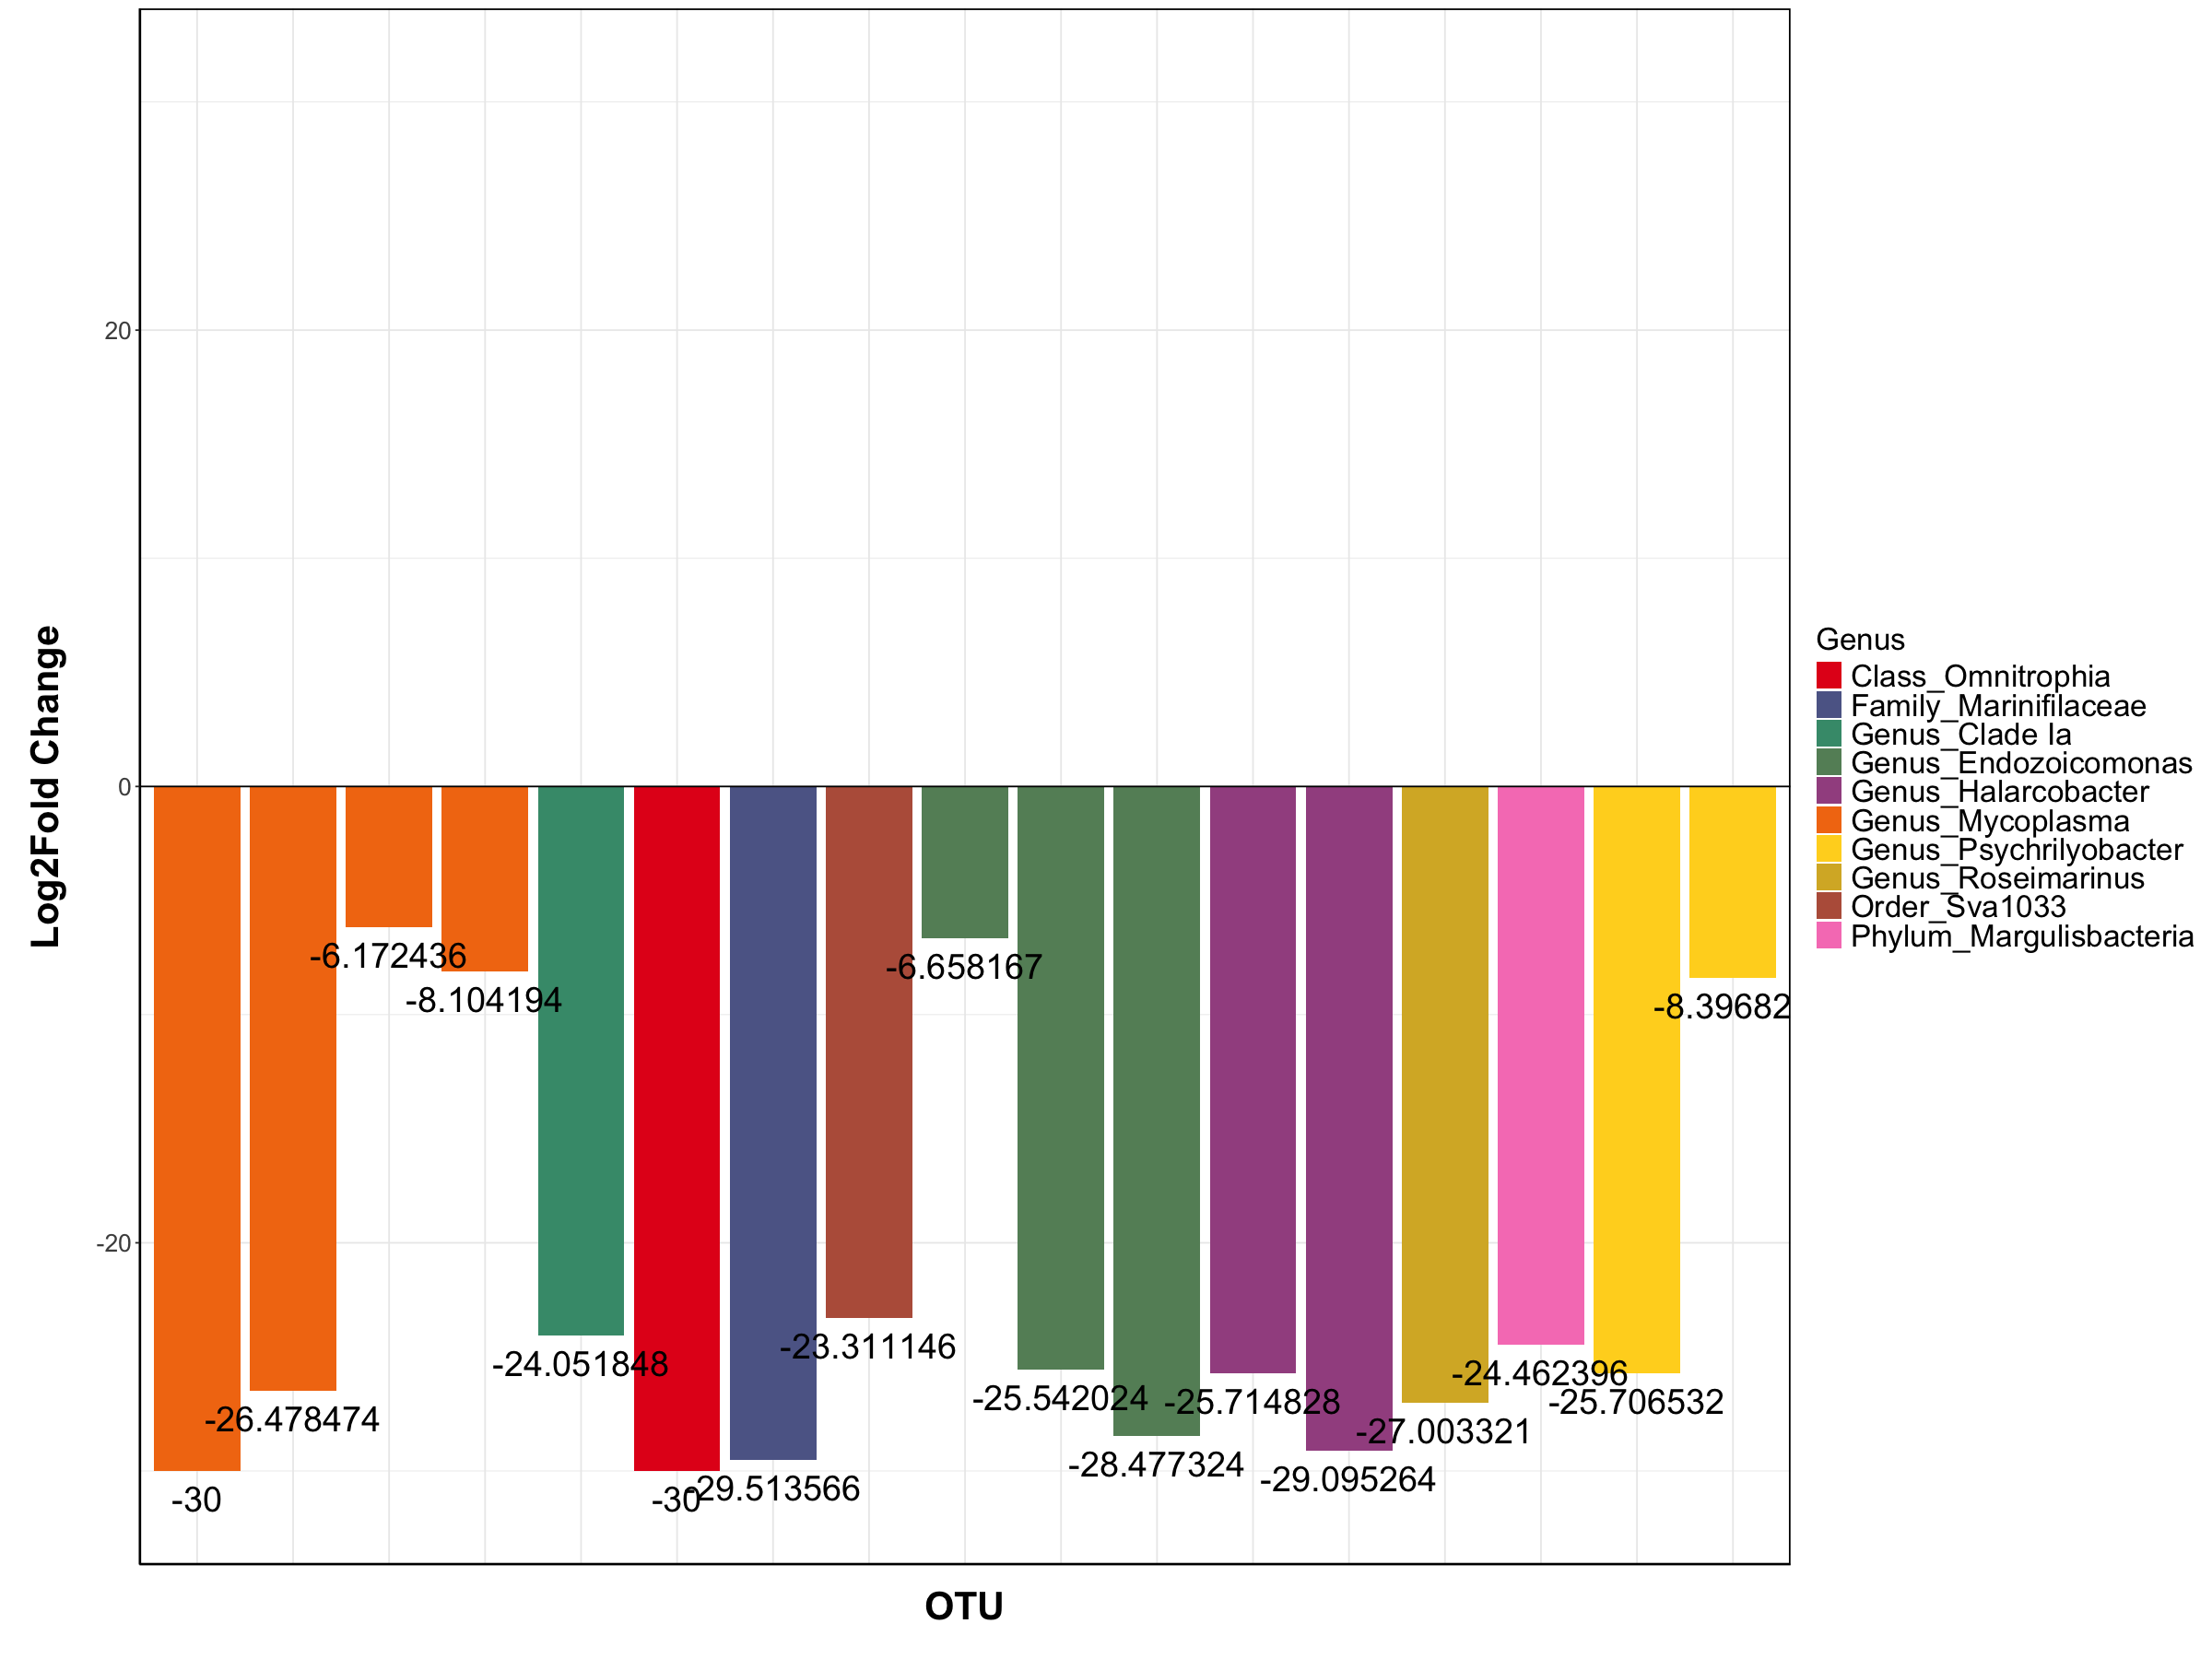

In [313]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(10)

ggplot(PeaLog,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-31, 31))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [314]:
ggsave(file="~/Documents/DE/Figures/Pea_bar.pdf", width = 15, height=10)

In [554]:
PeaLog$Peacrab=PeaLog$log2FoldChange
PeaLog$log2FoldChange=NULL

In [433]:
write.csv(PeaLog, "~/Documents/DE/DE_16S/Oyster16S_Data23/Results/PEA_SigOTUs.csv")

## significant otus 2017 weight and length

In [1017]:
DE17w=subset_samples(DE17, !is.na(Weight_delta))

In [1018]:
DE17w

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14184 taxa and 90 samples ]
sample_data() Sample Data:       [ 90 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 14184 taxa by 6 taxonomic ranks ]

In [1019]:
test=sample_data(DE17w)

In [1020]:
max(test$Length_delta)

[1] 3.061299

In [1021]:
dds_weight17 <- phyloseq_to_deseq2(DE17w, ~ Weight_delta+Length_delta)
dds_weight17 <- DESeq(dds_weight17, test="Wald", fitType="parametric")
resultsNames(dds_weight17)

converting counts to integer mode

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"    "Weight_delta" "Length_delta"

In [1022]:
resweight17 <- results(dds_weight17, name="Weight_delta")
sigweight17 <- resweight17[which(resweight17$padj < 0.05), ]
sigweight17 <- cbind(as(sigweight17, "data.frame"), as(tax_table(DE17w)[rownames(sigweight17), ], "matrix"))
sigweight17=sigweight17[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigweight17 <- as.matrix(sigweight17)

In [1023]:
##turn into phyloseq object
sigweight17TAX <- tax_table(sigweight17)
sigweight17_wlog <- DE17w
tax_table(sigweight17_wlog)=sigweight17TAX

In [1024]:
sigweight17_wlog

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 259 taxa and 90 samples ]
sample_data() Sample Data:       [ 90 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 259 taxa by 7 taxonomic ranks ]

In [1025]:
##filter for asvs found in 1/3 of samples
sigweight17_wlog_filter <- genefilter_sample(sigweight17_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigweight17_wlog))
sigweight17_wlog_prune <- prune_taxa(sigweight17_wlog_filter, sigweight17_wlog)

ERROR: Error in validObject(.Object): invalid class “otu_table” object: 
 OTU abundance data must have non-zero dimensions.


In [ ]:
tax_table(sigweight17_wlog_prune)

In [1026]:
reswvol17 <- results(dds_weight17, name="Length_delta")
sigvol17 <- reswvol17[which(reswvol17$padj < 0.05), ]
sigvol17 <- cbind(as(sigvol17, "data.frame"), as(tax_table(DE17w)[rownames(sigvol17), ], "matrix"))
sigvol17=sigvol17[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigvol17 <- as.matrix(sigvol17)

In [1027]:
##turn into phyloseq object
sigvol17TAX <- tax_table(sigvol17)
sigvol17_wlog <- DE17
tax_table(sigvol17_wlog)=sigvol17TAX

In [1028]:
##filter for asvs found in 1/3 of samples
sigvol17_wlog_filter <- genefilter_sample(sigvol17_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigvol17_wlog))
sigvol17_wlog_prune <- prune_taxa(sigvol17_wlog_filter, sigvol17_wlog)

ERROR: Error in validObject(.Object): invalid class “otu_table” object: 
 OTU abundance data must have non-zero dimensions.


In [1029]:
sigvol17_wlog_prune

ERROR: Error in eval(expr, envir, enclos): object 'sigvol17_wlog_prune' not found


In [ ]:
CV17vol_log=as.data.frame(tax_table(sigvol17_wlog_prune))

In [ ]:
CV17vol_log$CV17volume=CV17vol_log$log2FoldChange
CV17vol_log$log2FoldChange=NULL

## 2018 oysters

In [1030]:
DE18CV=subset_samples(DE18, Species=="CV")

In [1031]:
DE18CVw=subset_samples(DE18CV, !is.na(Weight_delta))

In [1032]:
dds_weight18CV <- phyloseq_to_deseq2(DE18CVw, ~ Weight_delta+Length_delta)
dds_weight18CV <- DESeq(dds_weight18CV, test="Wald", fitType="parametric")
resultsNames(dds_weight18CV)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"    "Weight_delta" "Length_delta"

In [938]:
resweight18CV <- results(dds_weight18CV, name="Weight_delta")
sigweight18CV <- resweight18CV[which(resweight18CV$padj < 0.05), ]
sigweight18CV <- cbind(as(sigweight18CV, "data.frame"), as(tax_table(DE18CVw)[rownames(sigweight18CV), ], "matrix"))
sigweight18CV=sigweight18CV[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigweight18CV <- as.matrix(sigweight18CV)

In [939]:
##turn into phyloseq object
sigweight18CVTAX <- tax_table(sigweight18CV)
sigweight18CV_wlog <- DE18CVw
tax_table(sigweight18CV_wlog)=sigweight18CVTAX

In [940]:
##filter for asvs found in 1/3 of samples
sigweight18CV_wlog_filter <- genefilter_sample(sigweight18CV_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigweight18CV_wlog))
sigweight18CV_wlog_prune <- prune_taxa(sigweight18CV_wlog_filter, sigweight18CV_wlog)

In [941]:
##Heattree
weight18CV=sigweight18CV_wlog_prune
tax_table(weight18CV) <- tax_table(weight18CV)[,2:7]
taxmapweight18CV <- parse_phyloseq(weight18CV)

The following 5 of 12 (41.7%) input indexes have `NA` in their classifications:
   1, 4, 7, 8, 9




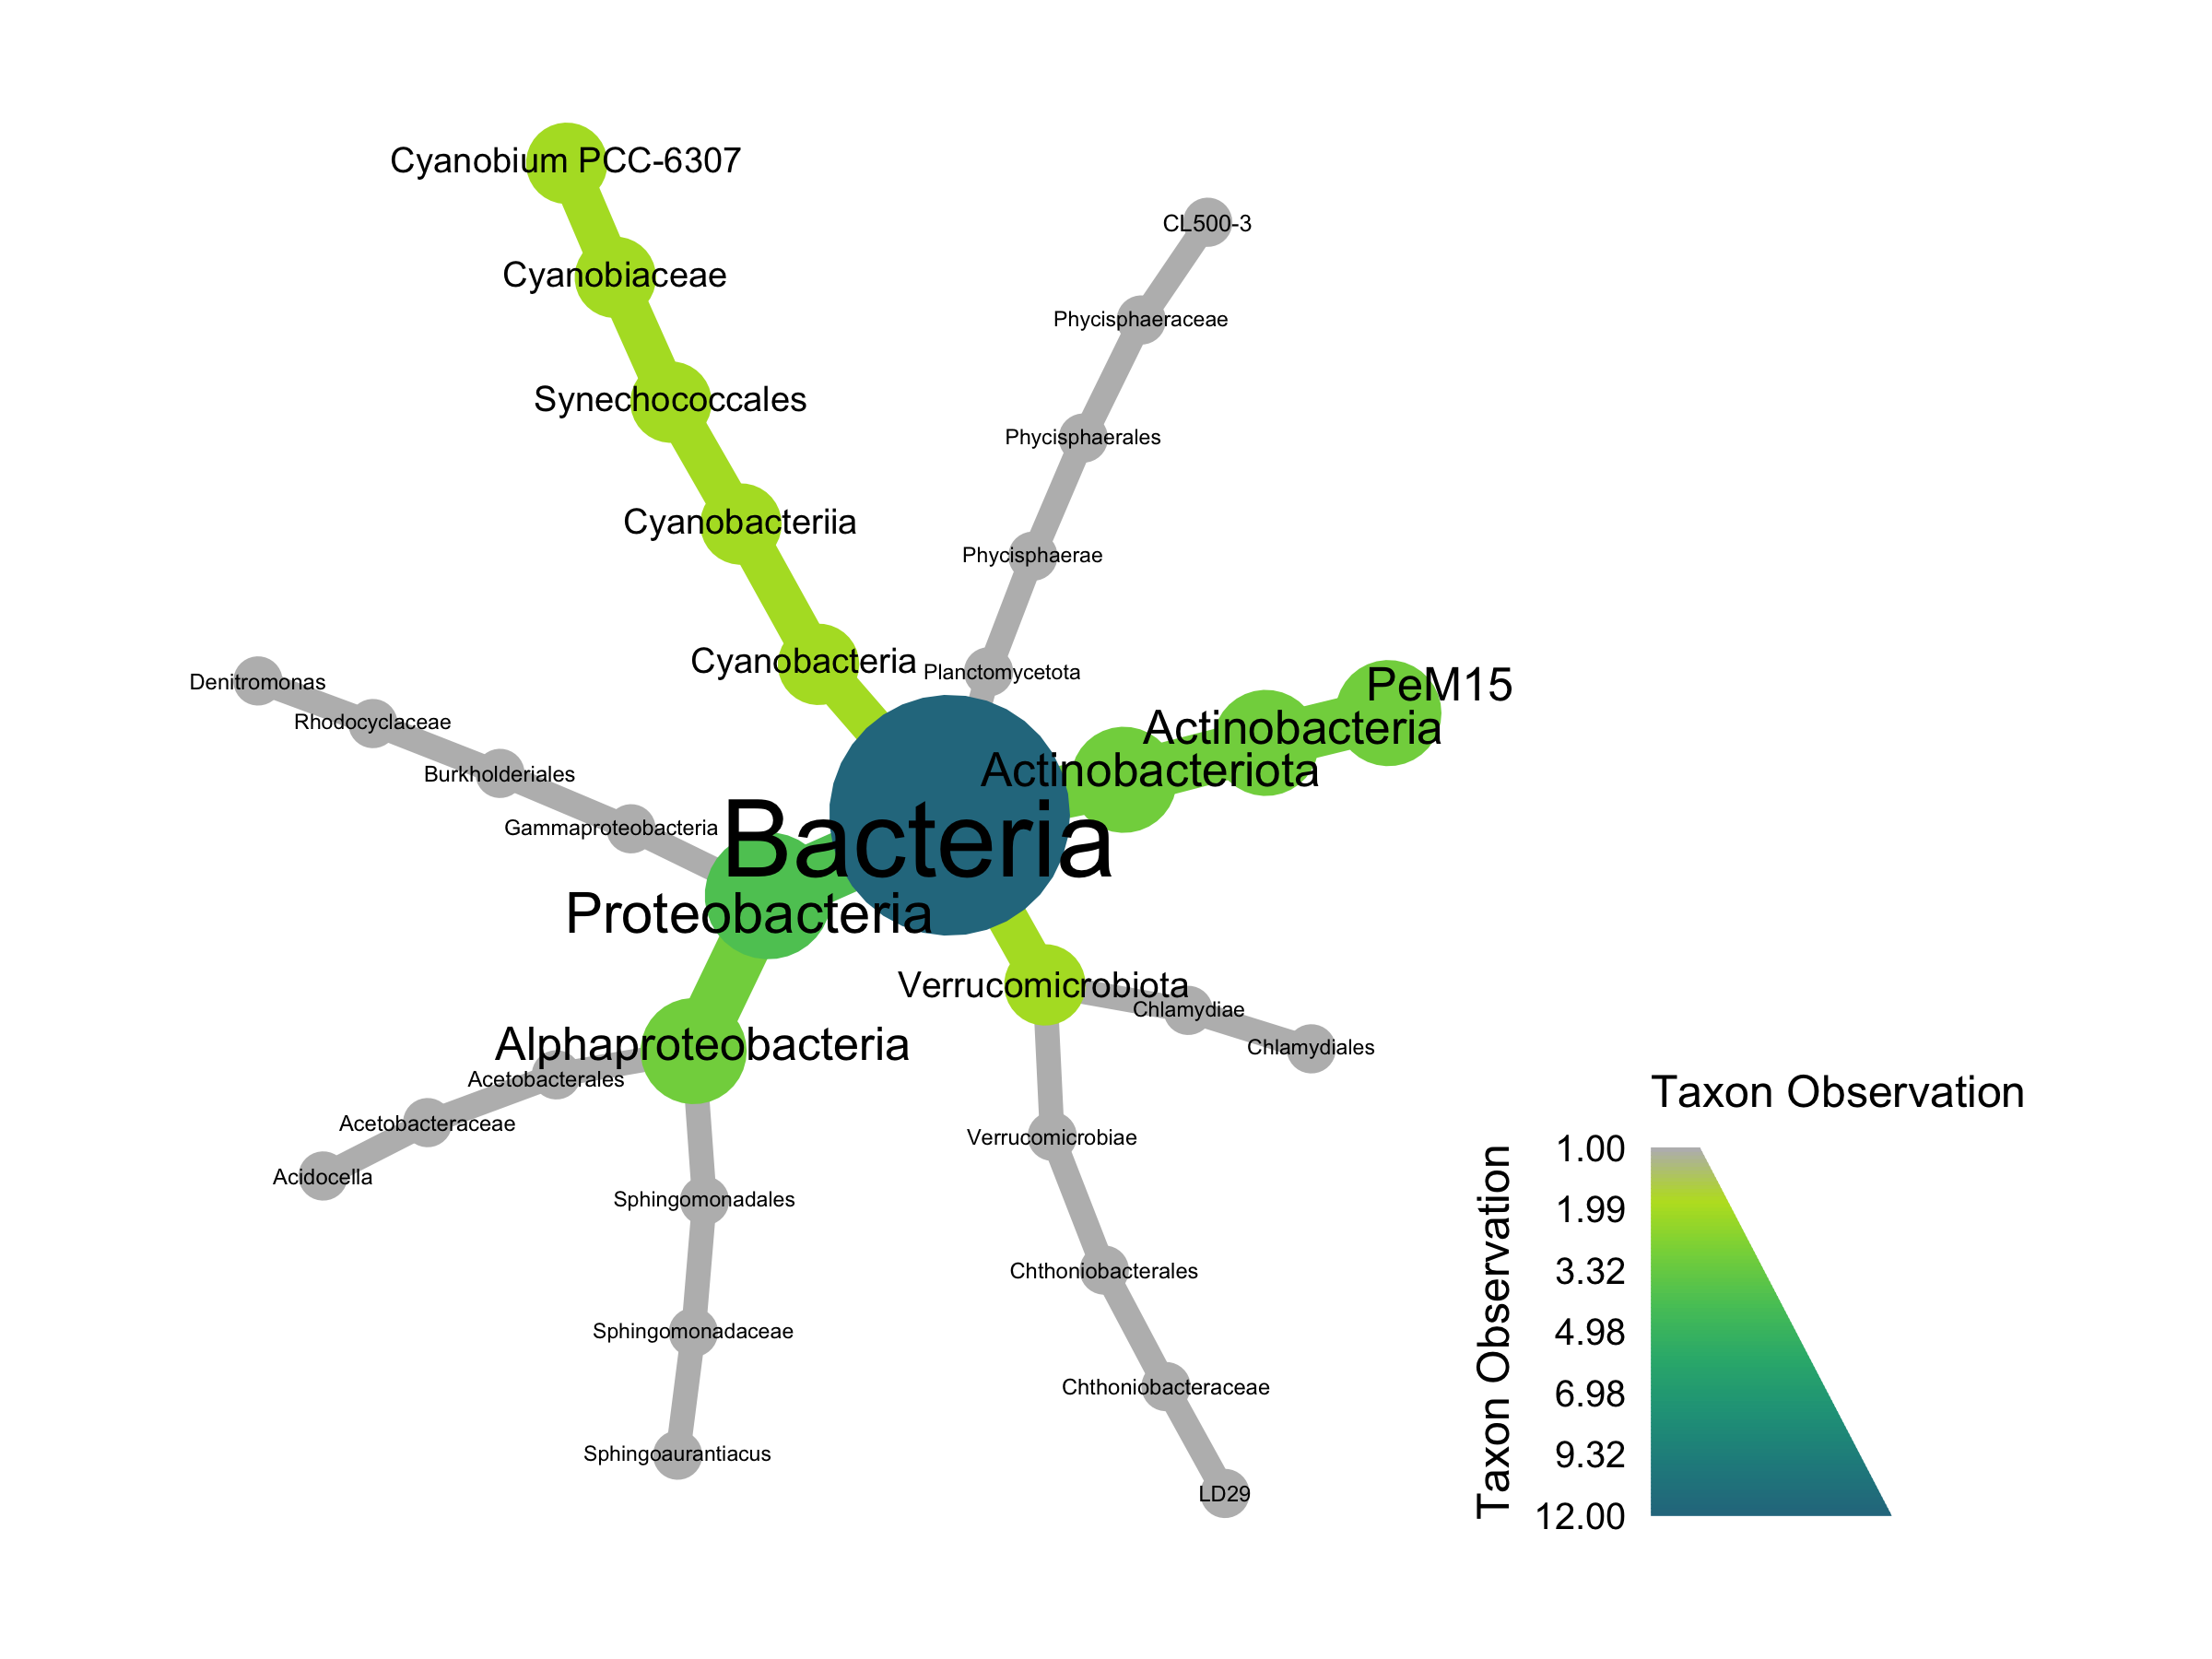

In [942]:
taxmapweight18CV %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapweight18CV),
            node_color = n_obs(taxmapweight18CV),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [943]:
ggsave(file="~/Documents/DE/Figures/Taxmap_CV18_weight.pdf", width = 15, height=10)

In [1033]:
##Fill in lowest taxonomic level for bargraph
weight18CV_df=as.data.frame(tax_table(sigweight18CV_wlog_prune))
for (i in colnames(weight18CV_df)[2:NCOL(weight18CV_df)]){
  weight18CV_df[[i]] <- (str_c(i, "_", weight18CV_df[[i]]))}

weight18CV_df=as.data.frame(t(weight18CV_df))
weight18CV_df=as.data.frame(t(fill(weight18CV_df, names(weight18CV_df))))
weight18CV_df$OTU=row.names(weight18CV_df)
weight18CV_df$log2FoldChange=as.numeric(weight18CV_df$log2FoldChange)

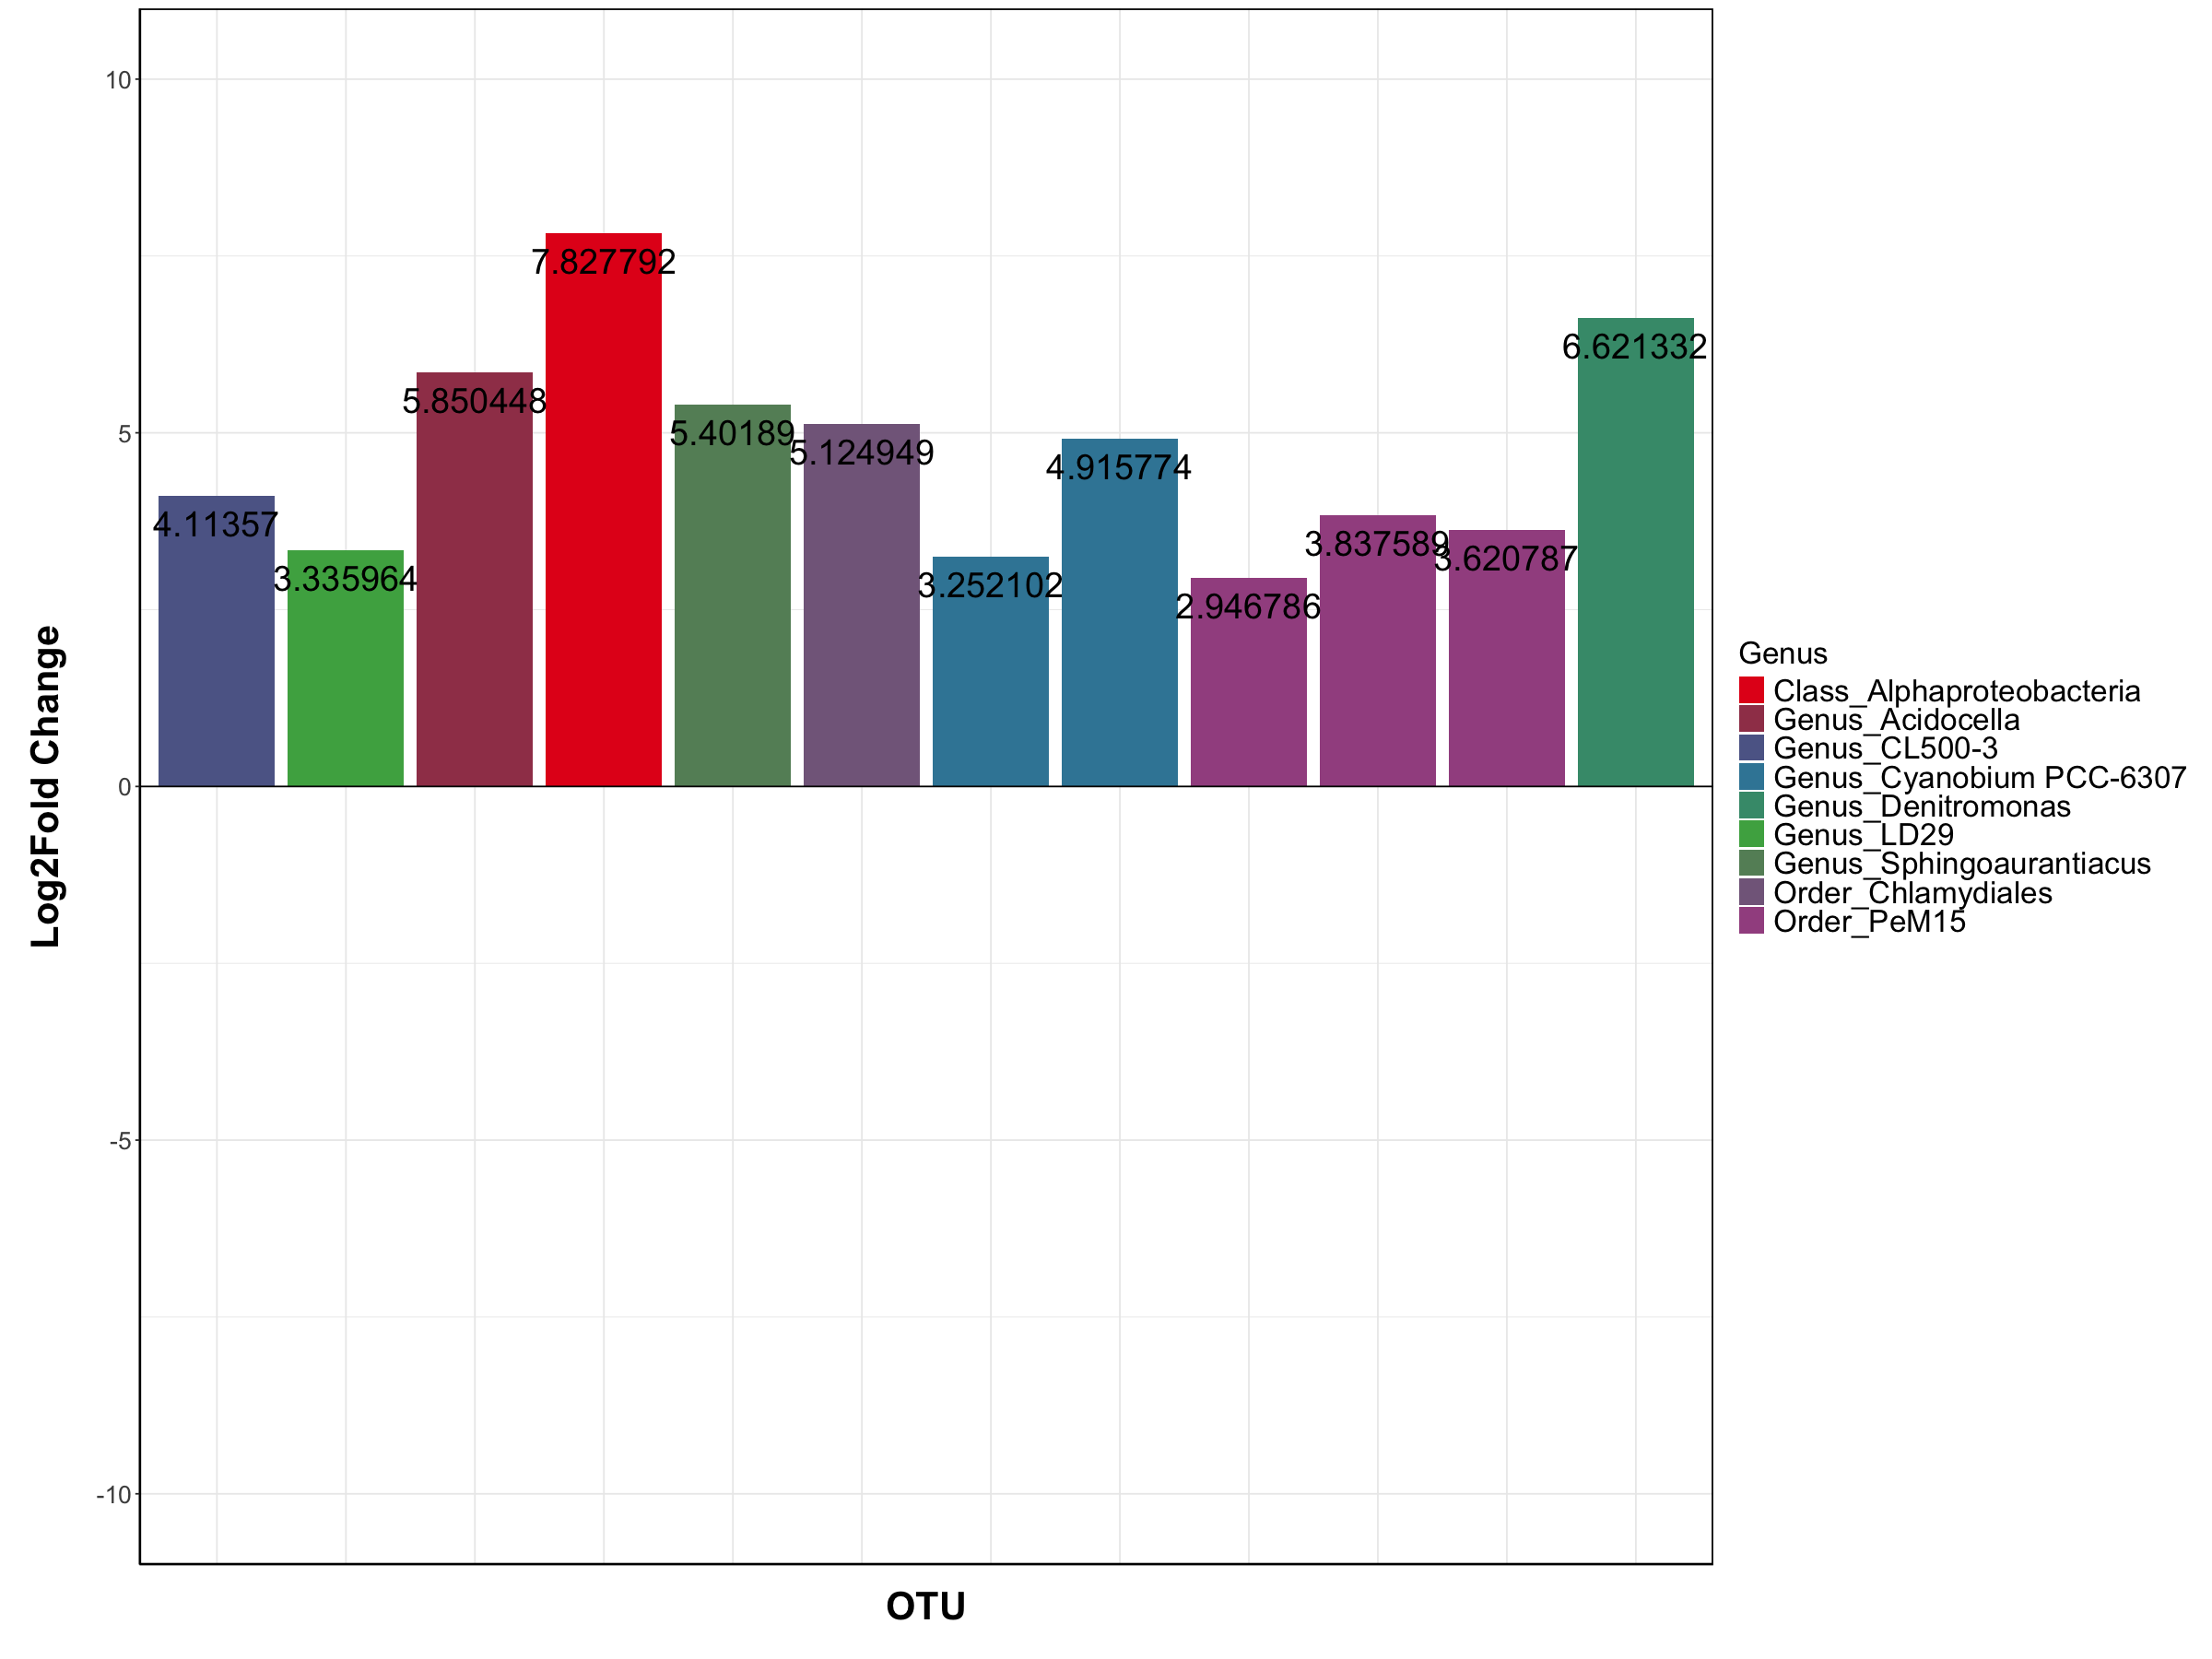

In [1034]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(19)

ggplot(weight18CV_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-10, 10))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [902]:
ggsave(file="~/Documents/DE/Figures/Bar_CV18_weight.pdf", width = 15, height=10)

In [1035]:
weight18CV_df$CV18weight=weight18CV_df$log2FoldChange
weight18CV_df$log2FoldChange=NULL

In [1037]:
resvol18CV <- results(dds_weight18CV, name="Length_delta")
sigvol18CV <- resvol18CV[which(resvol18CV$padj < 0.05), ]
sigvol18CV <- cbind(as(sigvol18CV, "data.frame"), as(tax_table(DE18CVw)[rownames(sigvol18CV), ], "matrix"))
sigvol18CV=sigvol18CV[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigvol18CV <- as.matrix(sigvol18CV)

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


In [1038]:
##turn into phyloseq object
sigvol18CVTAX <- tax_table(sigvol18CV)
sigvol18CV_wlog <- DE18CVw
tax_table(sigvol18CV_wlog)=sigvol18CVTAX

ERROR: Error in access(object, "tax_table", errorIfNULL): tax_table slot is empty.


In [1041]:
##filter for asvs found in 1/3 of samples
sigvol18CV_wlog_filter <- genefilter_sample(sigvol18CV_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigvol18CV_wlog))
sigvol18CV_wlog_prune <- prune_taxa(sigvol18CV_wlog_filter, sigvol18CV_wlog)

In [ ]:
##Heattree
vol18CV=sigvol18CV_wlog_prune
tax_table(vol18CV) <- tax_table(vol18CV)[,2:7]
taxmapvol18CV <- parse_phyloseq(vol18CV)

In [ ]:
taxmapvol18CV %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapvol18CV),
            node_color = n_obs(taxmapvol18CV),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [ ]:
#ggsave(file="~/Documents/DE/Figures/Taxmap_CV18_length.pdf", width = 15, height=10)

In [ ]:
##Fill in lowest taxonomic level for bargraph
vol18CV_df=as.data.frame(tax_table(sigvol18CV_wlog_prune))
for (i in colnames(weight18CV_df)[2:NCOL(vol18CV_df)]){
  vol18CV_df[[i]] <- (str_c(i, "_", vol18CV_df[[i]]))}

vol18CV_df=as.data.frame(t(vol18CV_df))
vol18CV_df=as.data.frame(t(fill(vol18CV_df, names(vol18CV_df))))
vol18CV_df$OTU=row.names(vol18CV_df)
vol18CV_df$log2FoldChange=as.numeric(vol18CV_df$log2FoldChange)

In [ ]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(17)

ggplot(vol18CV_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-30, 30))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), 
        text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)))+ 
        #panel.border = element_rect(color = "black",fill = NA,size = 1))+
      labs(x = "OTU",
       y = "Log2Fold Change")

In [ ]:
ggsave(file="~/Documents/DE/Figures/_CV18_length.pdf", width = 15, height=10)

In [ ]:
vol18CV_df$CV18vol=vol18CV_df$log2FoldChange
vol18CV_df$log2FoldChange=NULL

## 2018 Mussels

In [909]:
DE18IR=subset_samples(DE18, Species=="IR")
DE18IRw=subset_samples(DE18IR, !is.na(Weight_delta))

In [974]:
musseltest=sample_data(DE18IRw)

In [975]:
write.csv(musseltest, "~/Documents/DE/DE_16S/musseltest.csv")

In [966]:
dds_weight18IR <- phyloseq_to_deseq2(DE18IRw, ~ Weight_delta+Length_delta)
dds_weight18IR <- DESeq(dds_weight18IR, test="Wald", fitType="parametric")
resultsNames(dds_weight18IR)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"    "Weight_delta" "Length_delta"

In [967]:
resweight18IR <- results(dds_weight18IR, name="Weight_delta")
sigweight18IR <- resweight18IR[which(resweight18IR$padj < 0.05), ]
sigweight18IR <- cbind(as(sigweight18IR, "data.frame"), as(tax_table(DE18IRw)[rownames(sigweight18IR), ], "matrix"))
sigweight18IR=sigweight18IR[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigweight18IR <- as.matrix(sigweight18IR)

In [968]:
##turn into phyloseq object
sigweight18IRTAX <- tax_table(sigweight18IR)
sigweight18IR_wlog <- DE18IRw
tax_table(sigweight18IR_wlog)=sigweight18IRTAX

In [969]:
##filter for asvs found in 1/3 of samples
sigweight18IR_wlog_filter <- genefilter_sample(sigweight18IR_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigweight18IR_wlog))
sigweight18IR_wlog_prune <- prune_taxa(sigweight18IR_wlog_filter, sigweight18IR_wlog)

In [970]:
##Heattree
weight18IR=sigweight18IR_wlog_prune
tax_table(weight18IR) <- tax_table(weight18IR)[,2:7]
taxmapweight18IR <- parse_phyloseq(weight18IR)

The following 3 of 3 (100%) input indexes have `NA` in their classifications:
   1, 2, 3




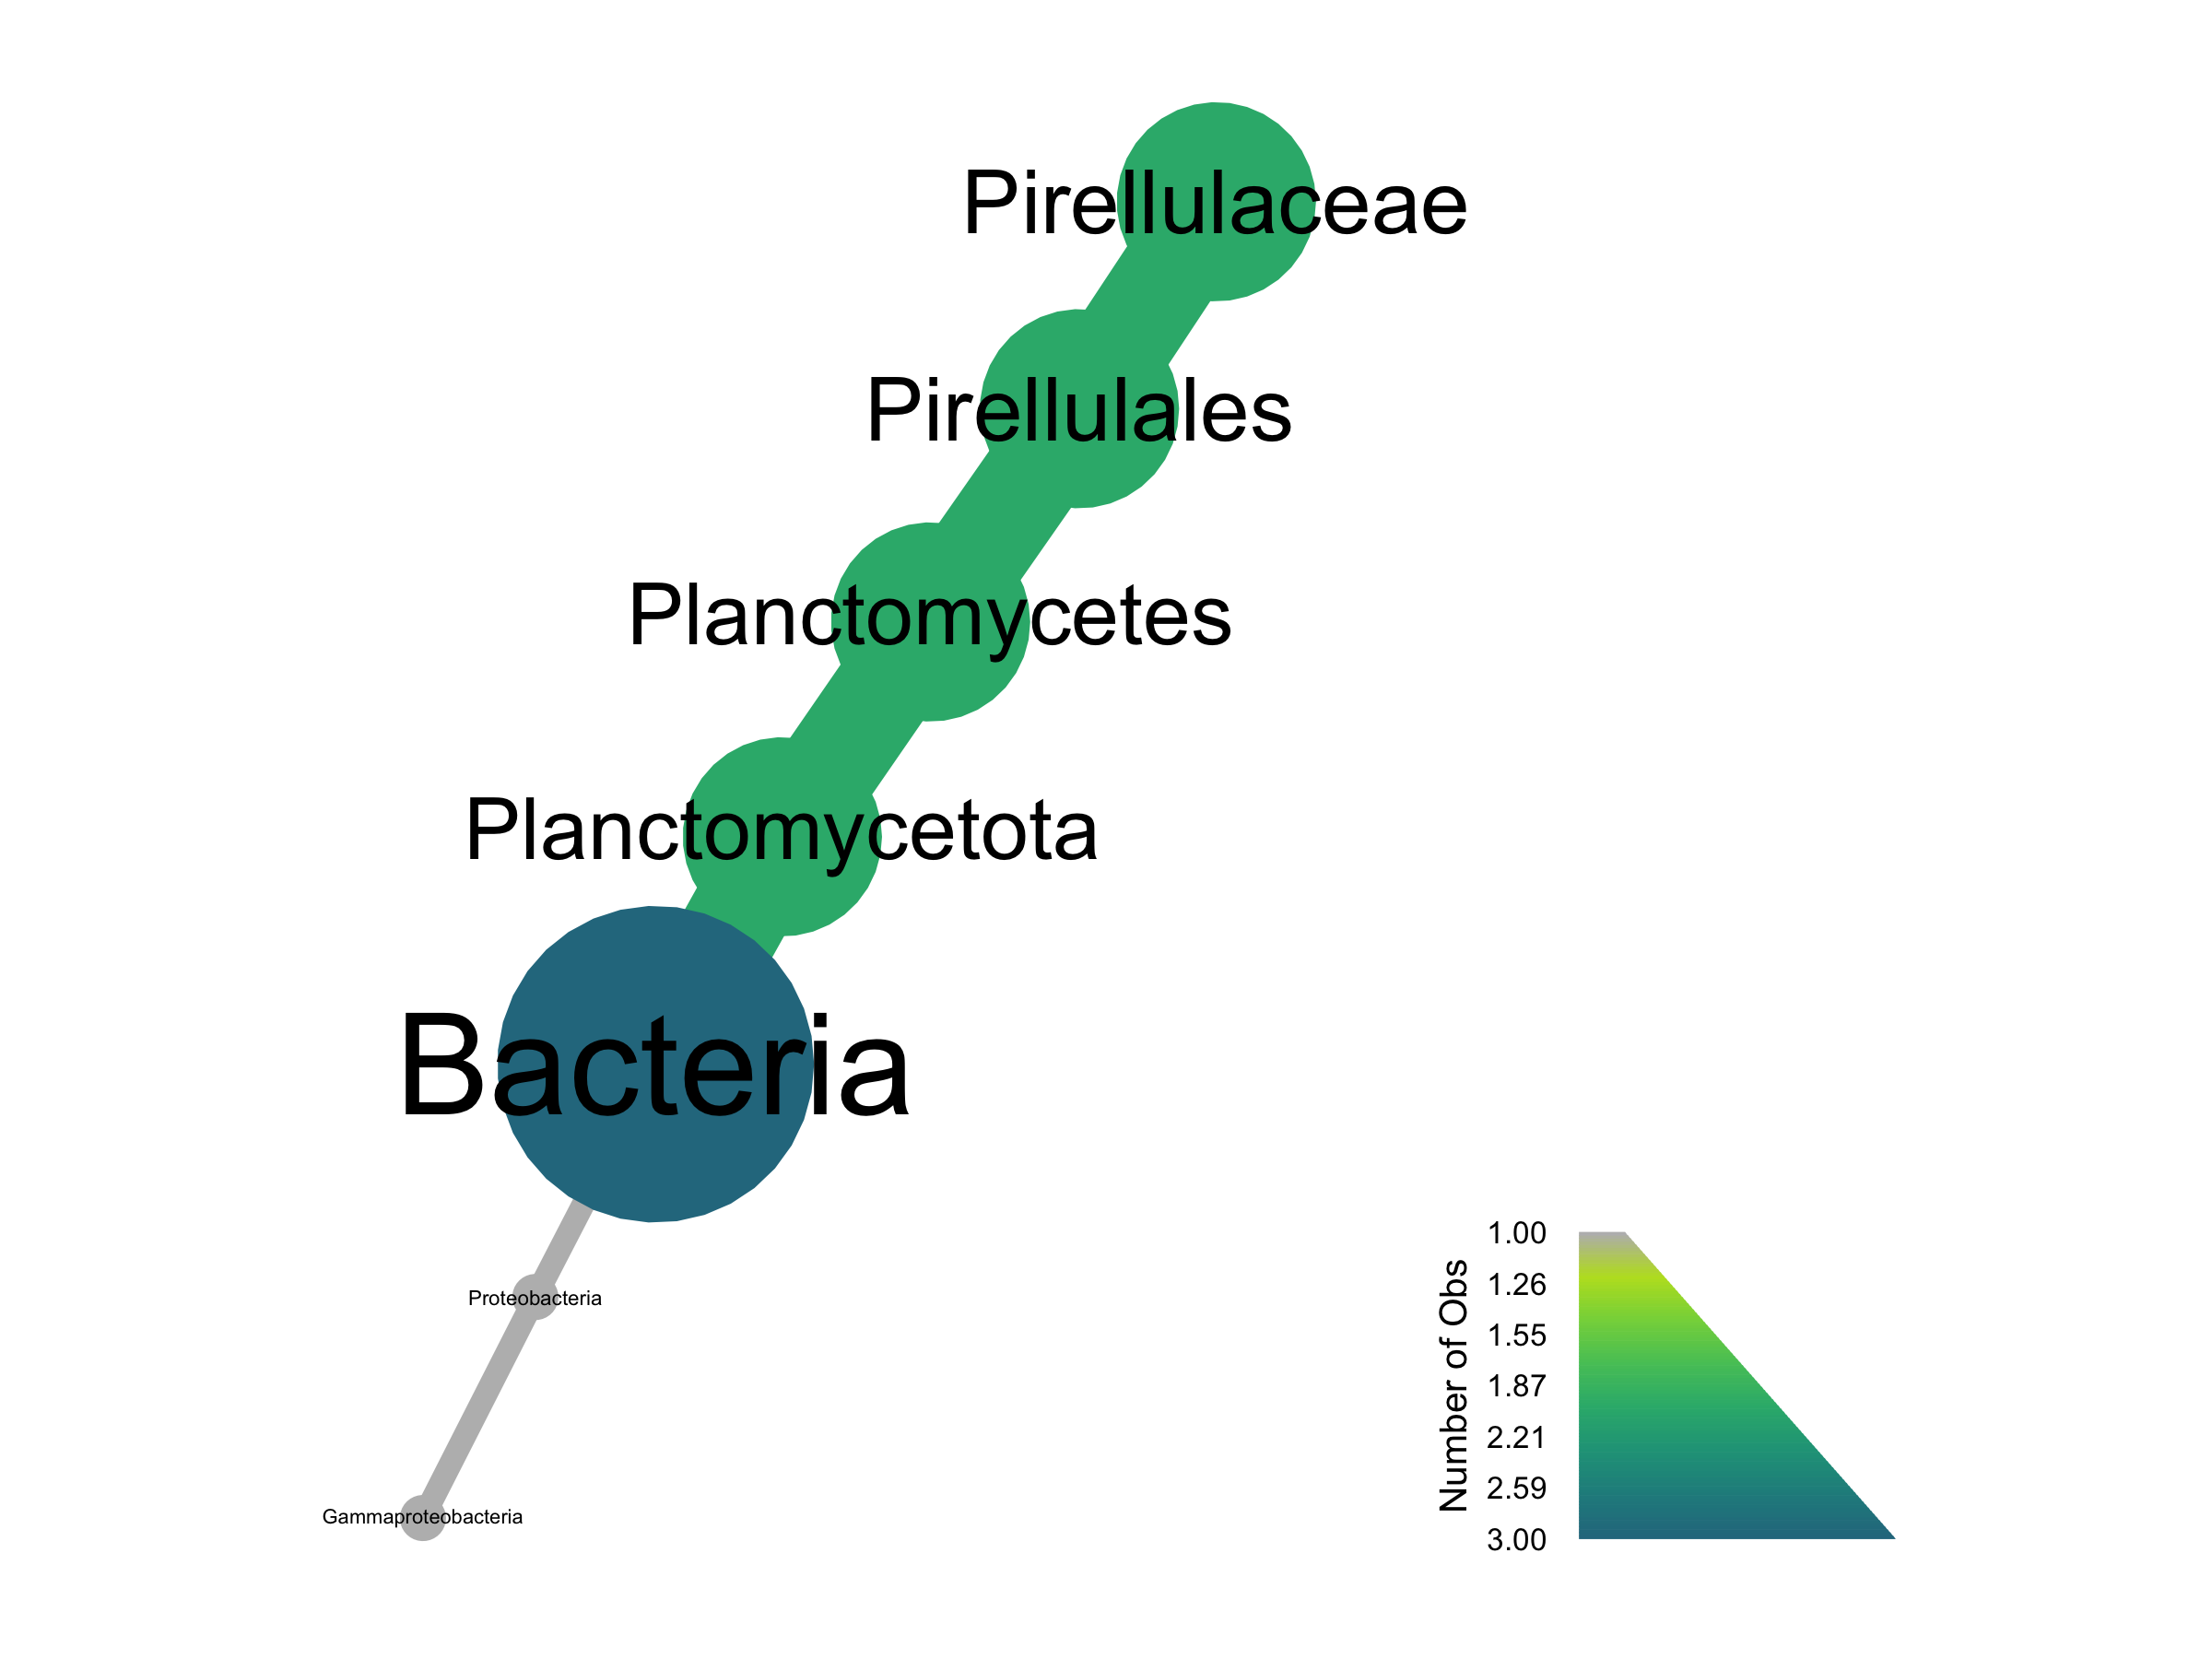

In [1049]:
taxmapweight18IR %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapweight18IR),
            node_color = n_obs(taxmapweight18IR),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= NULL, 
            node_color_axis_label ="Number of Obs",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [1050]:
ggsave(file="~/Documents/DE/Figures/IRweight_taxmap.pdf", width = 15, height=10)

In [1051]:
##Fill in lowest taxonomic level for bargraph
weight18IR_df=as.data.frame(tax_table(sigweight18IR_wlog_prune))
for (i in colnames(weight18CV_df)[2:NCOL(weight18IR_df)]){
  weight18IR_df[[i]] <- (str_c(i, "_", weight18IR_df[[i]]))}

weight18IR_df=as.data.frame(t(weight18IR_df))
weight18IR_df=as.data.frame(t(fill(weight18IR_df, names(weight18IR_df))))
weight18IR_df$OTU=row.names(weight18IR_df)
weight18IR_df$log2FoldChange=as.numeric(weight18IR_df$log2FoldChange)

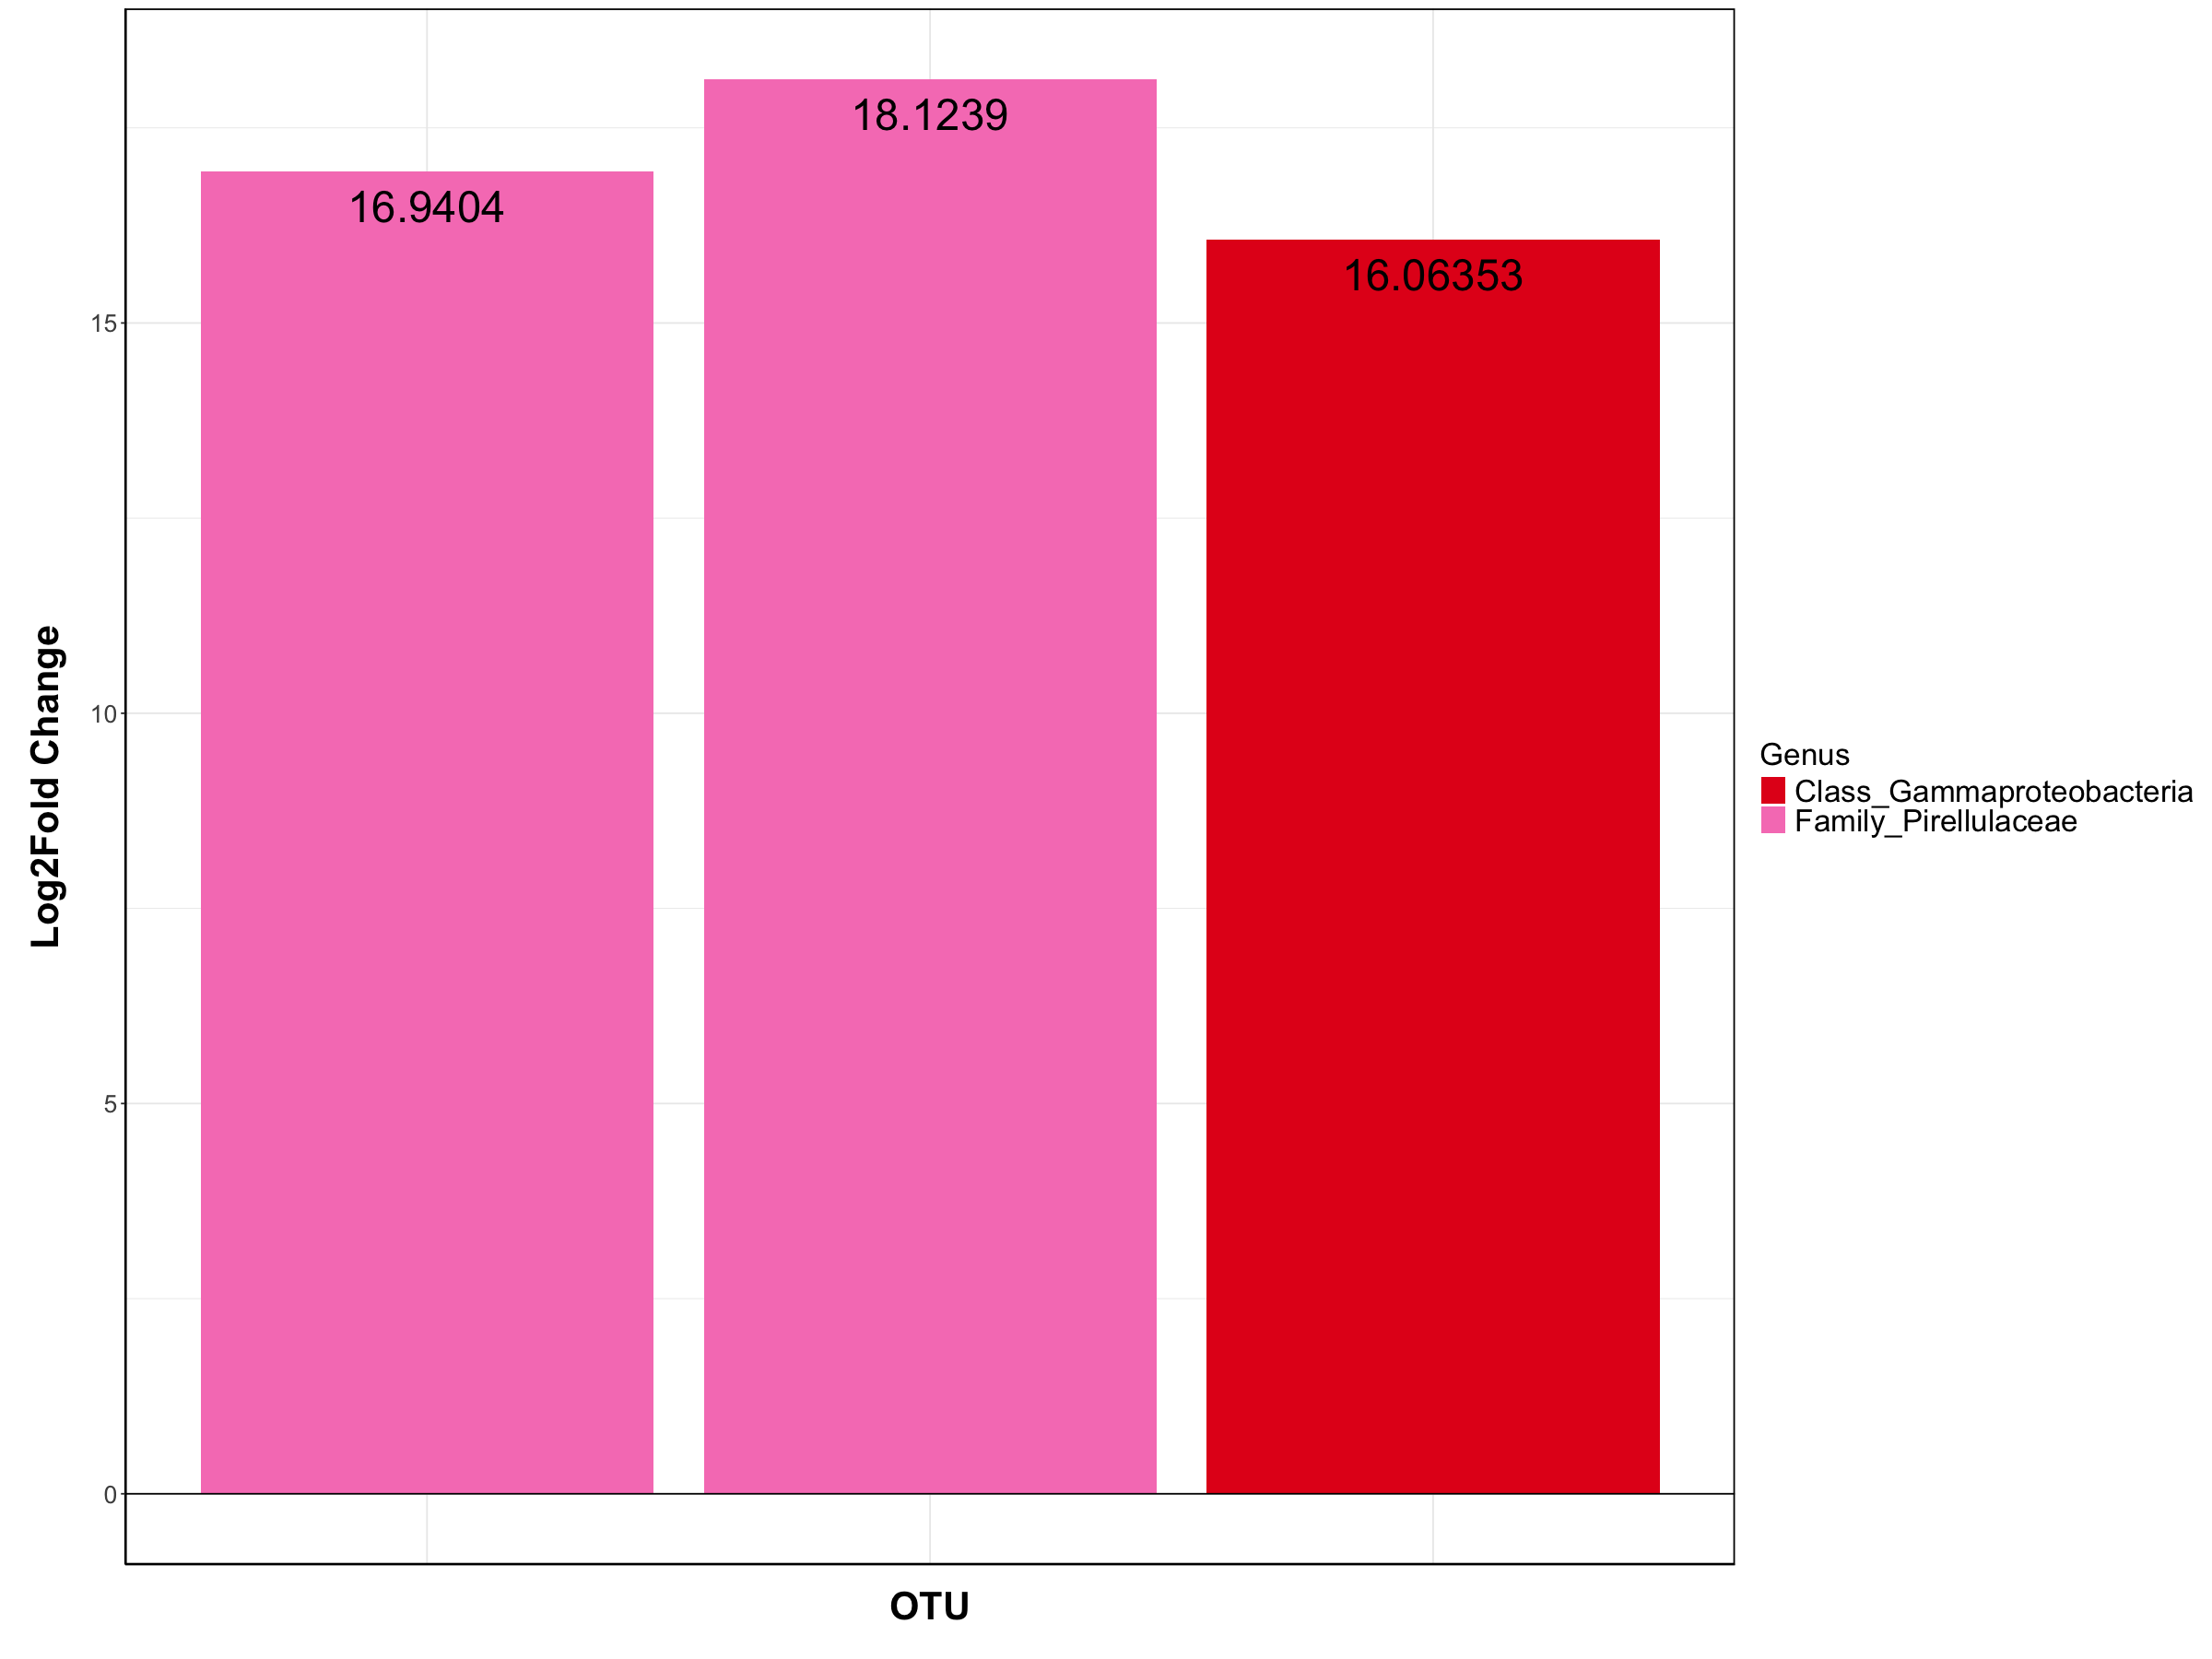

In [1057]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(2)

ggplot(weight18IR_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=10)+
scale_fill_manual(values = mycolors)+
  #scale_y_continuous(limits = c(-20, 20))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [1058]:
ggsave(file="~/Documents/DE/Figures/IRweight_bar.pdf", width = 15, height=10)

In [960]:
weight18IR_df$IR18weight=weight18IR_df$log2FoldChange
weight18IR_df$log2FoldChange=NULL

In [972]:
resweight18IR <- results(dds_weight18IR, name="Weight_delta")
sigweight18IR <- resweight18IR[which(resweight18IR$padj < 0.05), ]
sigweight18IR <- cbind(as(sigweight18IR, "data.frame"), as(tax_table(DE18IRw)[rownames(sigweight18IR), ], "matrix"))
sigweight18IR=sigweight18IR[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigweight18IR <- as.matrix(sigweight18IR)

In [973]:
resvol18IR <- results(dds_weight18IR, name="Length_delta")
sigvol18IR <- resvol18IR[which(resvol18IR$padj < 0.05), ]
sigvol18IR <- cbind(as(sigvol18IR, "data.frame"), as(tax_table(DE18IRw)[rownames(sigvol18IR), ], "matrix"))
sigvol18IR=sigvol18IR[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigvol18IR <- as.matrix(sigvol18IR)

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


In [ ]:
##turn into phyloseq object
sigvol18IRTAX <- tax_table(sigvol18IR)
sigvol18IR_wlog <- DE18IRw
tax_table(sigvol18IR_wlog)=sigvol18IRTAX

##filter for asvs found in 1/3 of samples
sigvol18IR_wlog_filter <- genefilter_sample(sigvol18IR_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigvol18IR_wlog))
sigvol18IR_wlog_prune <- prune_taxa(sigvol18IR_wlog_filter, sigvol18IR_wlog)

In [ ]:
tax_table(sigvol18IR_wlog_prune)

In [ ]:
##Fill in lowest taxonomic level for bargraph
vol18IR_df=as.data.frame(tax_table(sigvol18IR_wlog_prune))
for (i in colnames(vol18IR_df)[2:NCOL(vol18IR_df)]){
 vol18IR_df[[i]] <- (str_c(i, "_", vol18IR_df[[i]]))}
vol18IR_df=as.data.frame(t(vol18IR_df))
vol18IR_df=as.data.frame(t(fill(vol18IR_df, names(vol18IR_df))))
vol18IR_df$OTU=row.names(vol18IR_df)
vol18IR_df$log2FoldChange=as.numeric(vol18IR_df$log2FoldChange)


In [ ]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(12)

ggplot(vol18IR_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
geom_col(width = 0.05)+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-25, 25))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [ ]:
ggsave(file="~/Documents/DE/Figures/IRvol_bar.pdf", width = 15, height=10)

In [ ]:
vol18IR_df$IR18vol=vol18IR_df$log2FoldChange
vol18IR_df$log2FoldChange=NULL

In [194]:
vol18CV_df

Kingdom         
TACGTATGGGGCAAACGTTGTTCGGATTCACTGGGCGTAAAGAGTACGTAGGCTGTCGAGACAGTCAATGATCAAATCCCGTAGCTTAACTACGTGGTCGTTGTTGATACTACTCGACTAGAGTTTTATAGAGGTAGCGGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAGGAACACCAAAGGCGAAGGCAAGCTACTGGGTAAAAACTGACGCTGAGGTACGAAAGCCAGGGGAGCAAATGGG Kingdom_Bacteria
TACGGAGGATGCAAGTGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGTCTGGTAAGTCAGAGGTGAAAGACGGTGGCTCAACCATCGCAGTGCCCTTGATACTATTGGACTAGATTACATTGGAAGTAGGCGGAATGTGCGGTGTAGCGGTGAAATGCGCAGATATCGCACGGAACACCAATAGCGAAAGCAGCTTACTATACTGTTAATGACACTGAGGCACGAAAGCGTGGGTAGCAAATAGG Kingdom_Bacteria
TACGGGAGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGTCTTGTAAGTCTGTTGTTAAAGCGTGGAGCTTAACTCCATTTCAGCAATGGAAACTGTAAGACTAGAGTGTGGTAGGGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAGGCGCTCTGCTGGGCCATAACTGACGCTCATGGACGAAAGCCAGGGGAGCGAAAGGG Kingdom_Bacteria
GACGAACCGTACAAACGTTACTCGGAATTACTGGGCTTAAAGGGTGCGTAGGCTGCGCGGAAAGTTGGGTGTGAAAGCCCTCGGCTCAACCGAGGAATTGCATCCAAAACTACCGTGCTGGAGGGAGACAGAGGTAAGCGGAACTCAAGGTGGAGCGGTGAAATGCGTTGATATCTTGAGGAACACCGGTGGCGAAAGCGGCTTACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCTAAGGTAGCAAACGGG Kingdom_Bacteria
TACGGAGGGTGCAAGCGTTGTTCGGAATCATTGGGCGTAAAGAGCGTGTAGGCGGTCAGGTAAGTCAGATGTGAAAGCCCTGGGCTCAACCCAGGAAGTGCATTTGAAACTACCTAACTTGAGTACGGGAGAGGAAGGGGGAATTCCCGGTGTAGAGGTGAAATTCGTAGATATCGGGAGGAATACCGGTGGCGAAGGCGCCCTTCTGGACTGATACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG Kingdom_Bacteria
TACAGAGGGGGCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTGTTTTAAGTGAGATGTGCAATCCCCGAGCTCAACTTGGGAACTGCATCTCAGACTGGGACGCTAGAGTGCTGGAGAGGGTGGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGGCCACCTGGACAGTAACTGACGCTGAGGCGCGAAAGTGTGGGGAGCAAACAGG Kingdom_Bacteria
                                                                                                                                                                                                                                                              Phylum                 
TACGTATGGGGCAAACGTTGTTCGGATTCACTGGGCGTAAAGAGTACGTAGGCTGTCGAGACAGTCAATGATCAAATCCCGTAGCTTAACTACGTGGTCGTTGTTGATACTACTCGACTAGAGTTTTATAGAGGTAGCGGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAGGAACACCAAAGGCGAAGGCAAGCTACTGGGTAAAAACTGACGCTGAGGTACGAAAGCCAGGGGAGCAAATGGG Phylum_Spirochaetota   
TACGGAGGATGCAAGTGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGTCTGGTAAGTCAGAGGTGAAAGACGGTGGCTCAACCATCGCAGTGCCCTTGATACTATTGGACTAGATTACATTGGAAGTAGGCGGAATGTGCGGTGTAGCGGTGAAATGCGCAGATATCGCACGGAACACCAATAGCGAAAGCAGCTTACTATACTGTTAATGACACTGAGGCACGAAAGCGTGGGTAGCAAATAGG Phylum_Bacteroidota    
TACGGGAGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGTCTTGTAAGTCTGTTGTTAAAGCGTGGAGCTTAACTCCATTTCAGCAATGGAAACTGTAAGACTAGAGTGTGGTAGGGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAGGCGCTCTGCTGGGCCATAACTGACGCTCATGGACGAAAGCCAGGGGAGCGAAAGGG Phylum_Cyanobacteria   
GACGAACCGTACAAACGTTACTCGGAATTACTGGGCTTAAAGGGTGCGTAGGCTGCGCGGAAAGTTGGGTGTGAAAGCCCTCGGCTCAACCGAGGAATTGCATCCAAAACTACCGTGCTGGAGGGAGACAGAGGTAAGCGGAACTCAAGGTGGAGCGGTGAAATGCGTTGATATCTTGAGGAACACCGGTGGCGAAAGCGGCTTACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCTAAGGTAGCAAACGGG Phylum_Planctomycetota 
TACGGAGGGTGCAAGCGTTGTTCGGAATCATTGGGCGTAAAGAGCGTGTAGGCGGTCAGGTAAGTCAGATGTGAAAGCCCTGGGCTCAACCCAGGAAGTGCATTTGAAACTACCTAACTTGAGTACGGGAGAGGAAGGGGGAATTCCCGGTGTAGAGGTGAAATTCGTAGATATCGGGAGGAATACCGGTGGCGAAGGCGCCCTTCTGGACTGATACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG Phylum_Desulfobacterota
TACAGAGGGGGCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTGTTTTAAGTGAGATGTGCAATCCCCGAGCTCAACTTGGGAACTGCATCTCAGACTGGGACGCTAGAGTGCTGGAGAGGGTGGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGGCCACCTGGACAGTAACTGACGCTGAGGCGCGAAAGTGTGGGGAGCAAACAGG Phylum_Acidobacteriota 
                                                                                                                                                                                                                                                              Class                  
TACGTATGGGGCAAACGTTGTTCGGATTCACTGGGCGTAAAGAGTACGTAGGCTGTCGAGACAGTCAATGATCAAATCCCGTAGCTTAACTACGTGGTCGTTGTTGATACTACTCGACTAGAGTTTTATAGAG

In [197]:
CV18=merge(weight18CV_df, vol18CV_df, all=TRUE)

In [198]:
all18=merge(weight18IR_df, CV18 , all=TRUE)

In [200]:
all18

Kingdom          Phylum                  Class                    
1  Bacteria         Phylum_Acidobacteriota  Class_Holophagae         
2  Bacteria         Phylum_Bacteroidota     Class_Bacteroidia        
3  Bacteria         Phylum_Bacteroidota     Class_Bacteroidia        
4  Bacteria         Phylum_Bacteroidota     Class_Bacteroidia        
5  Bacteria         Phylum_Cyanobacteria    Class_Cyanobacteriia     
6  Bacteria         Phylum_Cyanobacteria    Class_Cyanobacteriia     
7  Bacteria         Phylum_Desulfobacterota Class_Syntrophobacteria  
8  Bacteria         Phylum_Firmicutes       Class_Bacilli            
9  Bacteria         Phylum_Planctomycetota  Class_Planctomycetes     
10 Bacteria         Phylum_Planctomycetota  Class_Planctomycetes     
11 Bacteria         Phylum_Proteobacteria   Class_Alphaproteobacteria
12 Bacteria         Phylum_Proteobacteria   Class_Alphaproteobacteria
13 Bacteria         Phylum_Spirochaetota    Class_Spirochaetia       
14 Kingdom_Bacteria Phylum_Proteobacteria   Class_Alphaproteobacteria
15 Kingdom_Bacteria Phylum_Proteobacteria   Class_Alphaproteobacteria
16 Kingdom_Bacteria Phylum_Proteobacteria   Class_Gammaproteobacteria
   Order                     Family                   
1  Order_Holophagales        Family_Holophagaceae     
2  Class_Bacteroidia         Class_Bacteroidia        
3  Order_Cytophagales        Order_Cytophagales       
4  Order_Flavobacteriales    Family_Flavobacteriaceae 
5  Order_Synechococcales     Family_Cyanobiaceae      
6  Order_Synechococcales     Family_Cyanobiaceae      
7  Order_Syntrophobacterales Order_Syntrophobacterales
8  Order_Mycoplasmatales     Family_Mycoplasmataceae  
9  Order_Isosphaerales       Family_Isosphaeraceae    
10 Order_Pirellulales        Family_Pirellulaceae     
11 Order_Acetobacterales     Family_Acetobacteraceae  
12 Order_SAR11 clade         Order_SAR11 clade        
13 Order_Spirochaetales      Family_Spirochaetaceae   
14 Order_Acetobacterales     Family_Acetobacteraceae  
15 Order_Sphingomonadales    Family_Sphingomonadaceae 
16 Class_Gammaproteobacteria Class_Gammaproteobacteria
   Genus                    
1  Family_Holophagaceae     
2  Class_Bacteroidia        
3  Order_Cytophagales       
4  Family_Flavobacteriaceae 
5  Genus_Cyanobium PCC-6307 
6  Genus_Cyanobium PCC-6307 
7  Order_Syntrophobacterales
8  Genus_Mycoplasma         
9  Family_Isosphaeraceae    
10 Family_Pirellulaceae     
11 Genus_Acidocella         
12 Order_SAR11 clade        
13 Family_Spirochaetaceae   
14 Genus_Acidocella         
15 Genus_Sphingoaurantiacus 
16 Class_Gammaproteobacteria
   OTU                                                                                                                                                                                                                                                           
1  TACAGAGGGGGCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTGTTTTAAGTGAGATGTGCAATCCCCGAGCTCAACTTGGGAACTGCATCTCAGACTGGGACGCTAGAGTGCTGGAGAGGGTGGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGGCCACCTGGACAGTAACTGACGCTGAGGCGCGAAAGTGTGGGGAGCAAACAGG 
2  TACGGAGGATGCAAGTGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGTCTGGTAAGTCAGAGGTGAAAGACGGTGGCTCAACCATCGCAGTGCCCTTGATACTATTGGACTAGATTACATTGGAAGTAGGCGGAATGTGCGGTGTAGCGGTGAAATGCGCAGATATCGCACGGAACACCAATAGCGAAAGCAGCTTACTATACTGTTAATGACACTGAGGCACGAAAGCGTGGGTAGCAAATAGG 
3  TACGGAGGGTGCAAGCGTTGTCCGGATTTATTGGGTTTAAAGGGTACGTAGGCGGCTAATTAAGTCAGAGGTGAAAAGCGAGAGCTCAACTTTCGTCTTGCCTCTGATACTGCTTAGCTTGAGTACTAAGAAGGTAGGCGGAATTGATGGTGTAGCGGTGAAATGCATAGATACCATCAGGAACACCGATTGCGAAGGCAGCTTACTGTAAAGTAACTGACGCTGATGTACGAAAGCATGGGTAGCGAACAGG 
4  TACGGAGGATCCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGTGGAAGATTAAGTCAGAGGTGAAATCCTGCAGCTCAACTGTAGAATTGCCTTTGATACTGGTTTTCTTGAATCATTATGAAGTAGTTAGAATATGTAGTGTAGCGGTGAAATGCATAGATATTACATAGAATACCAATTGCGAAGGCAGATTACTAATAATGTATTGACACTGATGGACGAAAGCGTGGGGAGCGAACAGG 
5  TACGGGAGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGCCTTTTAAGTCTGTTGTTAAAGCGTGGAGCTTAACTC

In [610]:
#IR18=merge(weight18IR_df, vol18IR_df, all=TRUE)

In [171]:
#parasite=merge(PALog, PeaLog, all=TRUE)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'merge': object 'PALog' not found


In [612]:
CV17=merge(parasite, CV17vol_log, all=TRUE)

In [613]:
CV=merge(CV17, CV18, all=TRUE)

In [614]:
all=merge(CV, IR18, all=TRUE)

In [615]:
all

Kingdom          Phylum                   Class                    
1  Bacteria         Phylum_Actinobacteriota  Class_Actinobacteria     
2  Bacteria         Phylum_Cyanobacteria     Class_Cyanobacteriia     
3  Bacteria         Phylum_Cyanobacteria     Class_Cyanobacteriia     
4  Bacteria         Phylum_Planctomycetota   Class_Phycisphaerae      
5  Bacteria         Phylum_Planctomycetota   Class_Planctomycetes     
6  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
7  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
8  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
9  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
10 Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
11 Bacteria         Phylum_Spirochaetota     Class_Spirochaetia       
12 Bacteria         Phylum_Verrucomicrobiota Class_Chlamydiae         
13 Bacteria         Phylum_Verrucomicrobiota Class_Verrucomicrobiae   
14 Bacteria         Phylum_Verrucomicrobiota Class_Verrucomicrobiae   
15 Bacteria         Proteobacteria           Gammaproteobacteria      
16 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
17 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
18 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
19 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
20 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
21 Kingdom_Bacteria Phylum_Campilobacterota  Class_Campylobacteria    
22 Kingdom_Bacteria Phylum_Campilobacterota  Class_Campylobacteria    
23 Kingdom_Bacteria Phylum_Campilobacterota  Class_Campylobacteria    
24 Kingdom_Bacteria Phylum_Desulfobacterota  Class_Desulfobacteria    
25 Kingdom_Bacteria Phylum_Desulfobacterota  Class_Desulfuromonadia   
26 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
27 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
28 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
29 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
30 Kingdom_Bacteria Phylum_Fusobacteriota    Class_Fusobacteriia      
31 Kingdom_Bacteria Phylum_Fusobacteriota    Class_Fusobacteriia      
32 Kingdom_Bacteria Phylum_Margulisbacteria  Phylum_Margulisbacteria  
33 Kingdom_Bacteria Phylum_Nitrospirota      Class_Nitrospiria        
34 Kingdom_Bacteria Phylum_Nitrospirota      Class_Nitrospiria        
35 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
36 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
37 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
38 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
39 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
40 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
41 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
42 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
43 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
44 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
45 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
46 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
47 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
48 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
49 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
50 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
51 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
52 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
53 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
54 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
55 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
56 Kingdom_Bacteria Phylum_

In [616]:
write.csv(all, file="~/Documents/DE/Figures/AllsigASVs.csv")

In [172]:
allsigcore_old=read.csv("~/Documents/DE/Figures/Allsig_coreASVs.csv")

In [174]:
allsigcore_old$CV17volume=NULL

In [175]:
allsigcore_old$CV18vol=NULL

In [176]:
allsigcore_old$CV18weight=NULL

In [177]:
allsigcore_old$IR18vol=NULL

In [178]:
allsigcore_old$IR18weight=NULL

In [201]:
allsigcore_new=merge(allsigcore_old, all18, all=TRUE)

In [202]:
head(allsigcore_new)

OTU                                                                                                                                                                                                                                                           
1 GACGAACCAAGCGAACGTTATTCGGAATTACTGGGCTTAAAGCGCGTGTAGGCGGATTGCCACGTCGGCTGTTGAAATCCCCCGGCTCAACCGGGGAACAGGCACCGATACGAGTGATCTTGAGGTGGGTAGGGGAGACTGGAACTTCCGGTGGAGCGGTGAAATGCGTTGAGATCGGAAGGAACGCCCGCGGCGAAAGCGAGTCTCTGGCCCCATACTGACGCTGAGACGCGAAAGCCAGGGGAGCAAACGGG
2 GACGAACCAAGCGAACGTTATTCGGAATTACTGGGCTTAAAGCGCGTGTAGGCGGATTGCCACGTCGGCTGTTGAAATCCCCCGGCTCAACCGGGGAACAGGCACCGATACGAGTGATCTTGAGGTGGGTAGGGGAGACTGGAACTTCCGGTGGAGCGGTGAAATGCGTTGAGATCGGAAGGAACGCCCGCGGCGAAAGCGAGTCTCTGGCCCCATACTGACGCTGAGACGCGAAAGCCAGGGGAGCAAACGGG
3 GACGAACCGTACAAACGTTACTCGGAATTACTGGGCTTAAAGGGTGCGTAGGCTGCGCGGAAAGTTGGGTGTGAAAGCCCTCGGCTCAACCGAGGAATTGCATCCAAAACTACCGTGCTGGAGGGAGACAGAGGTAAGCGGAACTCAAGGTGGAGCGGTGAAATGCGTTGATATCTTGAGGAACACCGGTGGCGAAAGCGGCTTACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCTAAGGTAGCAAACGGG 
4 GACGAACCGTACAAACGTTACTCGGAATTACTGGGCTTAAAGGGTGCGTAGGCTGCGCGGAAAGTTGGGTGTGAAAGCCCTCGGCTCAACCGAGGAATTGCATCCAAAACTACCGTGCTGGAGGGAGACAGAGGTAAGCGGAACTCAAGGTGGAGCGGTGAAATGCGTTGATATCTTGAGGAACACCGGTGGCGAAAGCGGCTTACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCTAAGGTAGCAAACGGG 
5 GACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGATTAGTAAGTTGGGAGTGAAAGCCCGGGGCTTAACCTCGGAACTGCTTTCAAAACTGCTAGTCTTGAGTGAAGTAGGGGATGATGGAATTCCTAGTGTAGAGGTGAAATTCTTAGATATTAGGAGGAACACCGGTGGCGAAGGCGGTCATCTGGACTTCAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG 
6 TACAGAGGGCTCGAGCGTTAATCGGAATCACTGGGCTTAAAGCGTGCGTAGGCGGGCGTGTAAGCATCTTGTGAAAGCCCCCGGCTCAACCGGGGAATTGCTTGGTGAACTGCACGTCTTGAGGCAAGTAGAGGTGGTCGGAACGATAGGTGGAGCGGTGAAATGCGTAGATATCTATCGGAACGCCAACGGAGAAGTCAGGCCACTGGGCTTGTTCTGACGCTGAGGCACGAAAGCGTGGGTAGCGAACGGG 
  Kingdom    Phylum                 Class                Order              
1 Bacteria   Phylum_Planctomycetota Class_Planctomycetes Order_Isosphaerales
2 Bacteria   Planctomycetota        Planctomycetes       Isosphaerales      
3 Bacteria   Phylum_Planctomycetota Class_Planctomycetes Order_Pirellulales 
4 Bacteria;   Planctomycetota;      Planctomycetes;      Pirellulales;      
5 Bacteria;  Proteobacteria;        Alphaproteobacteria;  Rickettsiales;    
6 Bacteria   Planctomycetota        Phycisphaerae        Phycisphaerales    
  Family                Genus                 Perkinsus Peacrab CV18density
1 Family_Isosphaeraceae Family_Isosphaeraceae NA        NA      NA         
2 Isosphaeraceae                              NA        NA      NA         
3 Family_Pirellulaceae  Family_Pirellulaceae  NA        NA      NA         
4  Pirellulacea                               NA        NA      NA         
5 Rickettsiaceae;        Candidatus Megaira   NA        NA      NA         
6 Phycisphaeraceae      CL500-3               NA        NA      NA         
  CV18diversity CVcore Ircore AMcore MBcore IR18weight CV18weight CV18vol  
1 NA            NA     NA     NA     NA     -12.05418  NA                NA
2 NA                                               NA  NA                NA
3 NA            NA     NA     NA     NA            NA  NA         -13.80036
4 NA                          Yes    Yes           NA  NA                NA
5 NA                          Yes                  NA  NA                NA
6 NA                                               NA  NA                NA

In [204]:
write.csv(allsigcore_new, file="~/Documents/DE/Figures/Allsig_coreASVs2.csv")